# **Bonabeau Model**

## **Overview**

Simulation of emergent social hierarchy via local interactions, using `Agent` and `Game` classes.

## **Structure**

0. **Model Implementation** — `Agent` and `Game` classes  
1. **Effect of Density  $\rho$** — Influence of population density  
2. **Grid Visualization** — Spatial hierarchy for different $\rho$  
3. **Hierarchy Strength $\sigma^2/N$** — How it varies with $\rho$  
4. **Influence of $\eta$** — Fight determinism (temperature)  
5. **Influence of $\mu$** — Status relaxation (memory loss)  
6. **Phase Diagram $(\eta, \rho)$** — Mapping of hierarchical regimes


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random as rd
import os
import tqdm
from PIL import Image

In [2]:
from joblib import Parallel, delayed

In [3]:
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [4]:
"""agent class"""

class Agent:
    def __init__(
        self,
        init_position: tuple[int],
        init_fitness: float,
        id=int,
    ):
        self.position_hist = [init_position]
        self.fitness_hist = [init_fitness]
        self.Pi_hist = [] 
        self.id = id
        self._Pi = None

        self.fights_won = 0
        self.fights_lost = 0
        self.Xi_hist = []
        self._Xi = None

    @property
    def position(self):
        return self.position_hist[-1]

    @property
    def fitness(self):
        return self.fitness_hist[-1]
    
    @property
    def Pi(self):
        return self._Pi

    @Pi.setter
    def Pi(self, value):
        self._Pi = value
        self.Pi_hist.append(value)

    @property
    def Xi(self):
        return self._Xi

    @Xi.setter
    def Xi(self, value):
        self._Xi = value
        self.Xi_hist.append(value)

    def add_unchanged_step(self):
        self.fitness_hist.append(self.fitness)

    def move_position(self, L):
        x, y = self.position

        move_axis = np.random.choice([0, 1])

        if move_axis == 0:
            dx = np.random.choice([-1, 1])
            x = int(np.clip(x + dx, 0, L-1))
        else:
            dy = np.random.choice([-1, 1])
            y = int(np.clip(y + dy, 0, L-1))
        self.position_hist.append((x, y))


In [30]:

"""game class"""

class Game:
    def __init__(
        self,
        N: int,
        mu: float,
        grid_size: int = 20,
        eta: float = 10,
        tracked_fixed: bool = True, 
        plot_final: bool = True
    ):
        # input args
        self.N = N
        self.mu = mu
        self.grid_size = grid_size
        self.eta = eta
        self.plot_final = plot_final

        # deduced args
        self.rho = self.N / (self.grid_size**2)

        # population and grid (fitness init is included)
        self.population = []
        self.grid = [[[] for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        self.init_population()

        # plots 
        if tracked_fixed: 
            self.tracked_ids = list(range(10))
        else: 
            self.tracked_ids = np.random.choice(self.N, size=10, replace=False)

    def play_game(self, t_max: int, save_every: int | None = None, Pi_update_every: int = 1):
        print(f"Rho : {self.rho}")
        for t in tqdm.tqdm(range(t_max)):
            if save_every is not None and t % save_every == 0:
                self.plot_current_situation(t)
            self.play_one_iter(update_Pi=(t % Pi_update_every == 0))
        if self.plot_final:
            self.plot_tracked_Pi()

    def play_one_iter(self, update_Pi: bool = True):
        # move 
        self.move_all_agents()

        # fight 
        self.check_and_do_fight()

        # <Pi>
        for agent in self.population:
            relaxed_fitness = agent.fitness - self.mu * np.tanh(agent.fitness)
            agent.fitness_hist[-1] = relaxed_fitness

        if update_Pi:
            self.update_all_Pi()
        else:
            for agent in self.population:
                agent.Pi_hist.append(agent.Pi)

        for agent in self.population:
            D, S = agent.fights_won, agent.fights_lost
            if D + S > 0:
                agent.Xi = D / (D + S)
            else:
                agent.Xi = 0.0

    def check_and_do_fight(self):
        """Checks if a fight should take place and does it in such a case."""
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                agents = self.grid[x][y]
                if agents and len(agents) > 1:
                    self.fight(agents[0], agents[1])
                    for a in agents[2:]:
                        a.add_unchanged_step()
                elif agents and len(agents) == 1:
                    agents[0].add_unchanged_step()

    def move_all_agents(self):
        """Move all agents by one step and update the grid."""
        # reset grid
        self.grid = [[[] for _ in range(self.grid_size)] for _ in range(self.grid_size)]

        for agent in self.population:
            agent.move_position(self.grid_size)
            x, y = agent.position
            self.grid[x][y].append(agent)

    def fight(self, agent_i, agent_j):
        hi, hj = agent_i.fitness, agent_j.fitness
        prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))

        if np.random.rand() < prob_i_wins:
            agent_i.fights_won += 1
            agent_j.fights_lost += 1
            agent_i.fitness_hist.append(hi + 1)
            agent_j.fitness_hist.append(hj - 1)
        else:
            agent_j.fights_won += 1
            agent_i.fights_lost += 1
            agent_i.fitness_hist.append(hi - 1)
            agent_j.fitness_hist.append(hj + 1)

    def update_all_Pi(self):
        """Vectorized version: compute Pi for all agents using numpy."""
        fitnesses = np.array([agent.fitness for agent in self.population]) 
        
        diff_matrix = fitnesses[np.newaxis, :] - fitnesses[:, np.newaxis]  
        np.fill_diagonal(diff_matrix, np.nan)

        P = 1 / (1 + np.exp(self.eta * diff_matrix))  
        Pi_vector = np.nanmean(P, axis=1)  
        for agent, Pi in zip(self.population, Pi_vector):
            agent.Pi = Pi

    def compute_sigma2(self):
        """Compute the global hierarchy measure sigma2² = sum (Xi - 0.5)^2"""
        Xi_values = np.array([agent.Xi for agent in self.population])
        sigma2 = np.sum((Xi_values - 0.5) ** 2)
        return sigma2

    #_____________________________________ INIT _____________________________________ 

    def init_population(self):
        """Place N agents at random positions on the grid with initial fitness = 0.0"""
        positions = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size)]

        if self.N > len(positions):
            raise ValueError("Grid is too small to place all agents without overlap.")

        np.random.shuffle(positions)

        for i in range(self.N):
            pos = positions[i]
            agent = Agent(init_position=pos, init_fitness=0.0, id=i)
            self.population.append(agent)
            x, y = pos
            self.grid[x][y].append(agent)


    #_____________________________________ PLOTS _____________________________________ 

    def plot_tracked_Pi(self):
        plt.figure(figsize=(6, 4))
        for i in self.tracked_ids:
            agent = self.population[i]
            plt.plot(agent.Pi_hist, label=f"Agent {i}")
        plt.xlabel("Iterations")
        plt.ylabel("$<P_i>$")
        #plt.title("Evolution of the instantaneous probability that individual $i$ wins in a random fight")
        plt.legend(loc = "center right")
        plt.grid(True, alpha=0.3, linestyle="--")
        plt.tight_layout()
        plt.show()
    
    def animate_agents(self, interval=100, save_gif=False, gif_name="animation.gif", n_frames=100):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(-1, self.grid_size)
        ax.set_ylim(-1, self.grid_size)
        ax.set_title("")

        scatter = ax.scatter([], [], c=[], cmap='viridis', s=80, edgecolors='k')
        norm = mcolors.Normalize(vmin=0, vmax=1)

        # Ajouter la colorbar
        cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax)
        cbar.set_label(r"$\Pi$ (hiérarchie sociale)")

        def init():
            scatter.set_offsets(np.empty((0, 2)))
            scatter.set_array(np.array([]))
            return scatter,

        def update(frame):
            self.play_one_iter()

            # Positions et Pi
            positions = np.vstack([agent.position for agent in self.population])
            Pi_values = np.array([agent.Pi for agent in self.population])

            # Mettre à jour le scatter plot
            scatter.set_offsets(positions)
            scatter.set_array(Pi_values)
            scatter.set_norm(norm)

            # Mettre à jour le titre avec le numéro de frame
            ax.set_title(f"Évolution des agents — itération {frame+1}", fontsize=12)

            return scatter,

        anim = FuncAnimation(
            fig, update, init_func=init, frames=n_frames, interval=interval, blit=True
        )

        if save_gif:
            anim.save(gif_name, writer='pillow', fps=1000 // interval)
        else:
            plt.show()

    def plot_fitness(self, t_max, plot: bool = False):
        """Plot the fitness evolution during the game for all agents."""
        plt.figure(figsize=(6, 4))
        #plt.title("Fitness evolution for all agents")
        
        for agent in tqdm.tqdm(self.population):
            assert len(agent.fitness_hist) == t_max + 1
            plt.plot(agent.fitness_hist, alpha=0.7)

        plt.xlabel("Time")
        plt.ylabel("Fitness")
        plt.grid(True)
        plt.tight_layout()

        if plot:
            plt.show()
        else:
            plt.savefig("fitness_all_agents.png")
        plt.close()

    def plot_current_situation(self, step: int, plot: bool = False):
        """Scatter plot of agent positions at a given time, colored by fitness."""
        fig, ax = plt.subplots(figsize=(6, 6))
        #fig.suptitle(f"Time {step} and $\\rho = $ {np.round(self.rho,1)}")

        positions = np.array([agent.position for agent in self.population])
        fitnesses = np.array([agent.fitness for agent in self.population])

        sc = ax.scatter(
            positions[:, 0],
            positions[:, 1],
            c=fitnesses,
            cmap='viridis',
            vmin=np.min(fitnesses),
            vmax=np.max(fitnesses),
            s=80,
            edgecolors='k'
        )

        fig.colorbar(sc, ax=ax, label="Fitness")
        ax.set_title("All agents")
        ax.grid(True, alpha=0.5, linestyle="--")
        # ax.set_xticks(np.arange(self.grid_size + 1))
        # ax.set_yticks(np.arange(self.grid_size + 1))
        # ax.set_aspect("equal")
        ax.set_xlim((-0.5, self.grid_size + 0.5))
        ax.set_ylim((-0.5, self.grid_size + 0.5))
        plt.tight_layout()

        if plot:
            plt.show()
        else:
            os.makedirs("interactions/plots_grid", exist_ok=True)
            plt.savefig(f"interactions/plots_grid/step_{step}_rho_{np.round(self.rho,2)}.png", dpi=100)
        plt.close()


# **1- Experiments on $\rho$**

In [8]:
### Params
N = 500
mu=0.1
eta=5

Rho : 0.10204081632653061


 38%|███▊      | 1923/5000 [00:47<01:12, 42.70it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/3372403719.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
100%|██████████| 5000/5000 [02:22<00:00, 35.14it/s]


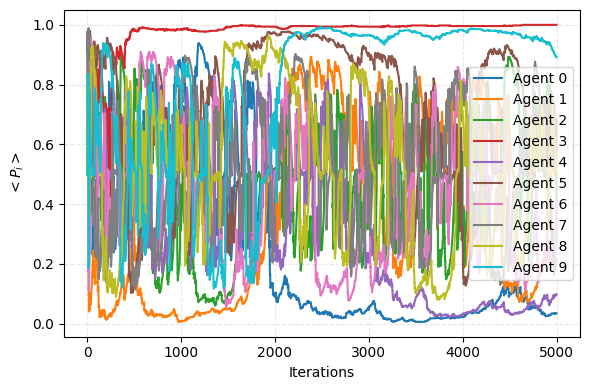

In [9]:
### Rho 0.1 ==> Erratic behavior
rho = 0.1
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000)

Rho : 0.2


  6%|▋         | 314/5000 [00:06<01:50, 42.60it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/3372403719.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
 12%|█▏        | 621/5000 [00:13<01:35, 46.01it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/3372403719.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5000/5000 [02:04<00:00, 40.08it/s]


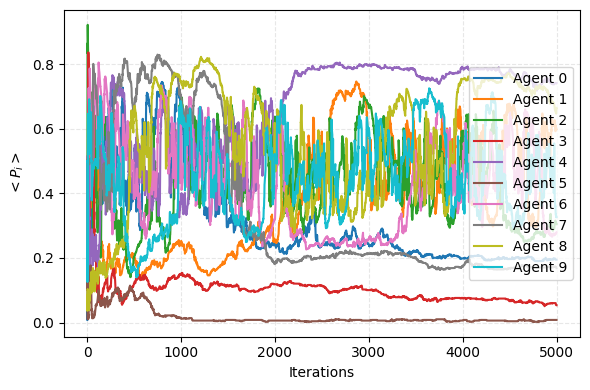

In [10]:
### Rho 0.2 
rho = 0.2
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000)

Rho : 0.5202913631633714


  3%|▎         | 159/5000 [00:03<01:45, 45.78it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/3372403719.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
  4%|▍         | 194/5000 [00:04<01:45, 45.35it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/3372403719.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5000/5000 [01:51<00:00, 45.00it/s]


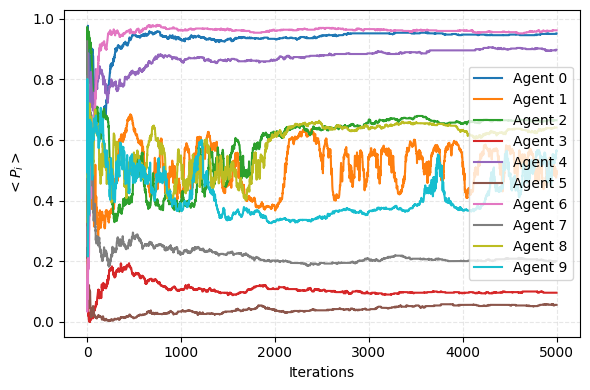

In [16]:
### Rho 0.5

rho = 0.5
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000)

Rho : 0.8


  2%|▏         | 121/5000 [00:03<01:39, 49.02it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/3372403719.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
  3%|▎         | 136/5000 [00:03<01:40, 48.30it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/3372403719.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5000/5000 [01:46<00:00, 46.85it/s]


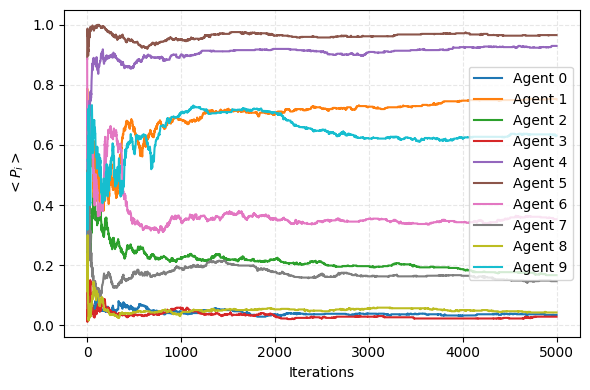

In [12]:
### Rho 0.8 >> rho C 

rho = 0.8
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5000)

In [64]:
# game = Game(N=N, mu=mu, grid_size=50, eta=5)
# game.animate_agents(interval=100, save_gif=True, gif_name="agents.gif")

# **2- Visualization of hierarchy on the grid, for different values of $\rho$**

In [31]:
### Params
N = 500
mu=0.1
eta=5

Rho : 0.10204081632653061


 33%|███▎      | 1627/5001 [00:40<01:28, 38.30it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/367723082.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
 67%|██████▋   | 3362/5001 [01:30<00:58, 28.06it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/367723082.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5001/5001 [02:25<00:00, 34.30it/s]


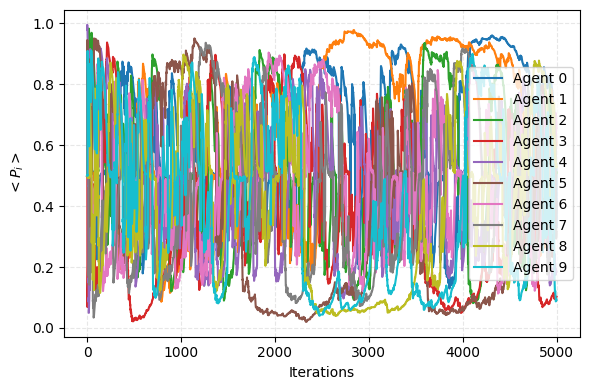

100%|██████████| 500/500 [00:00<00:00, 640.56it/s] 


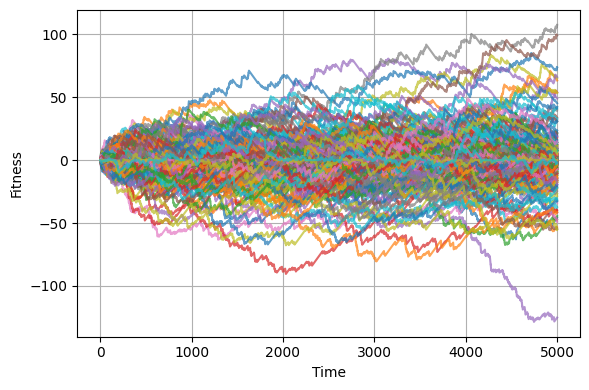

In [32]:
### Rho 0.1
rho = 0.1
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5001, save_every=500)
game.plot_fitness(t_max=5001, plot=True)


Rho : 0.5202913631633714


  3%|▎         | 170/5001 [00:03<01:34, 50.90it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/367723082.py:112: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(self.eta * diff_matrix))
  4%|▍         | 206/5001 [00:04<01:41, 47.42it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_70760/367723082.py:92: RuntimeWarning: overflow encountered in exp
  prob_i_wins = 1 / (1 + np.exp(self.eta * (hj - hi)))
100%|██████████| 5001/5001 [01:48<00:00, 46.02it/s]


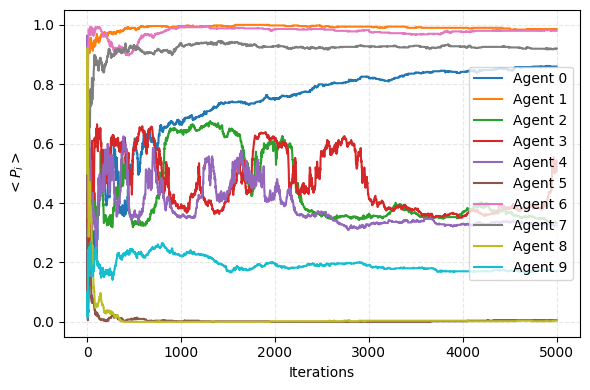

100%|██████████| 500/500 [00:00<00:00, 802.03it/s]


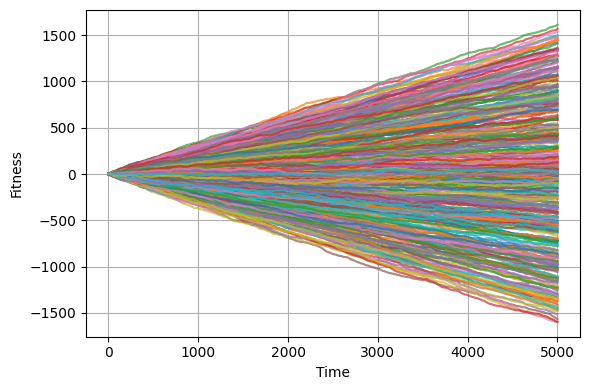

In [33]:
### Rho 0.5
rho = 0.5
grid_size = int(np.sqrt(N/rho))

game = Game(
    N=N,         # nombre d'agents
    mu=mu,       # relaxation
    grid_size=grid_size, # taille de la grille
    eta=eta       # paramètre dans les proba de victoire
)

game.play_game(t_max=5001, save_every=500)
game.plot_fitness(t_max=5001, plot=True)

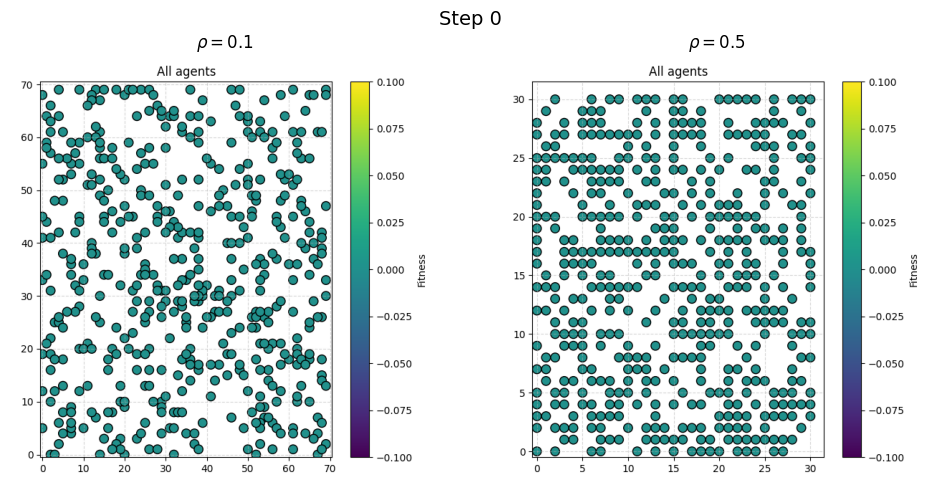

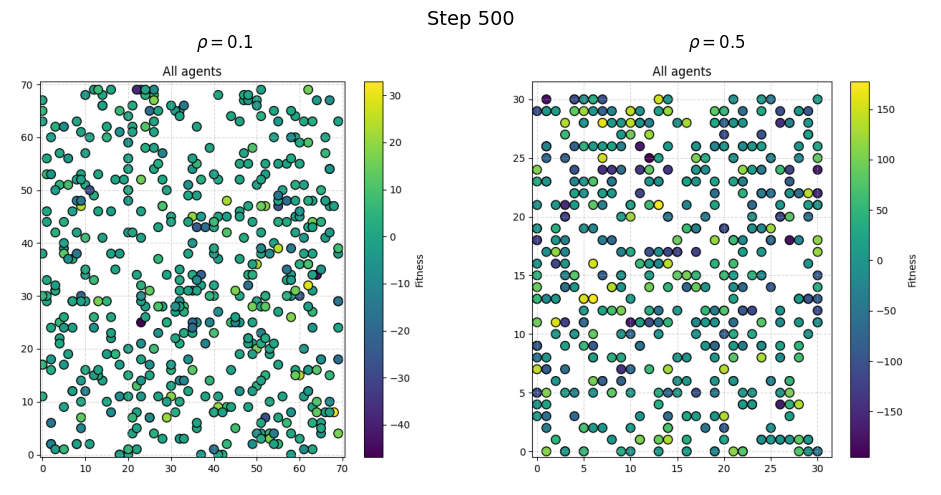

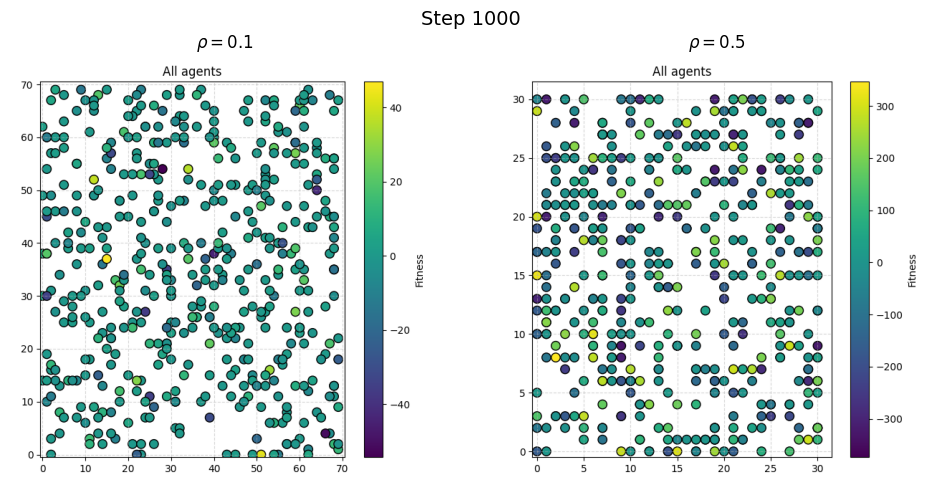

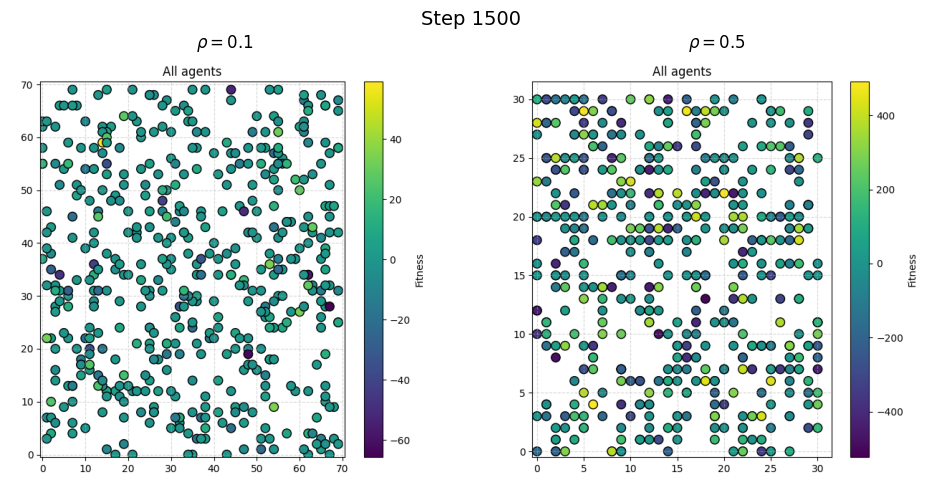

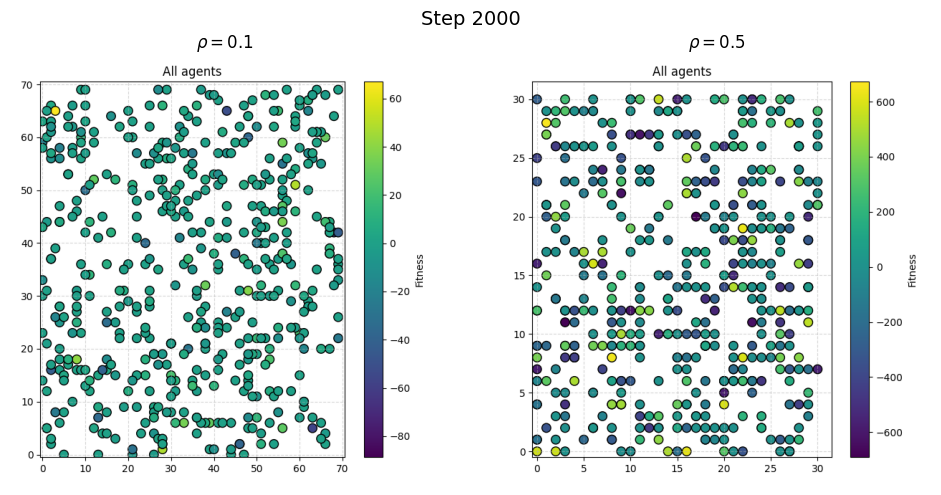

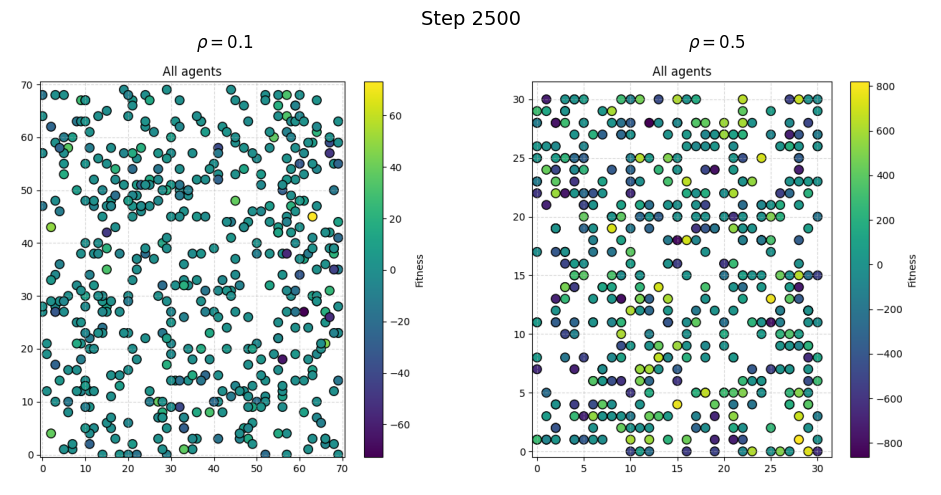

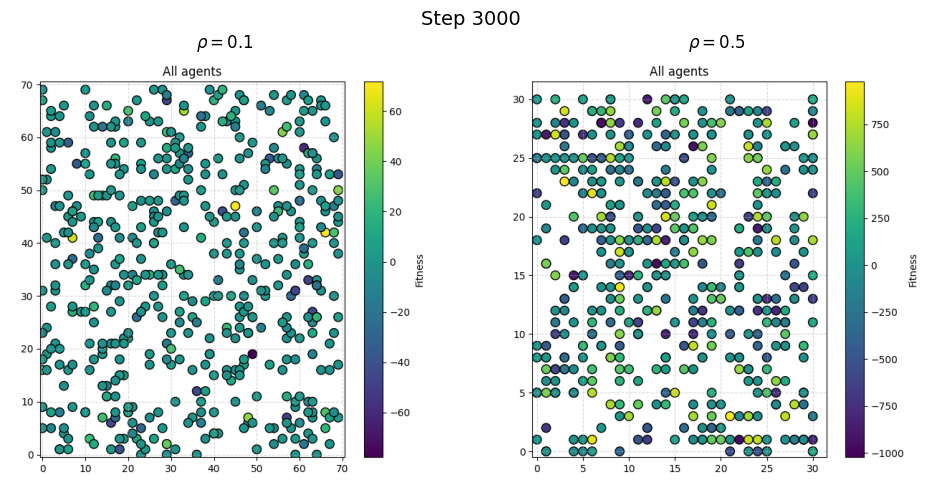

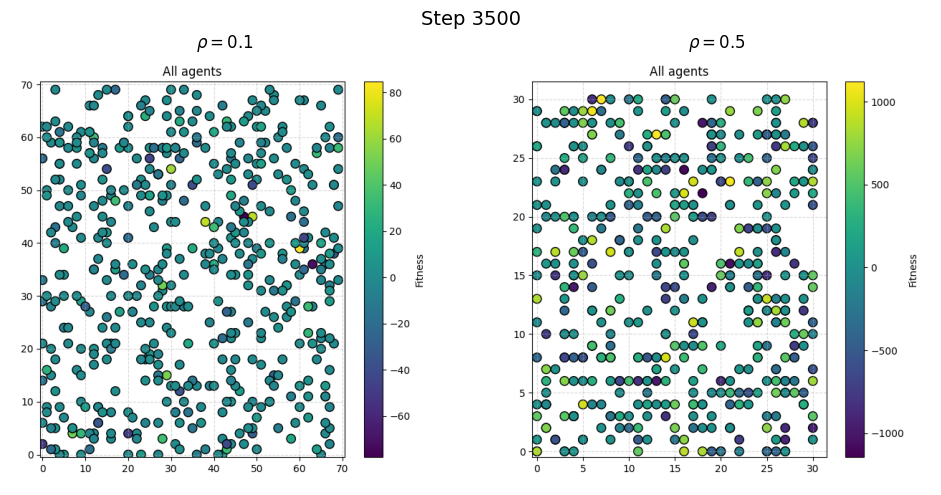

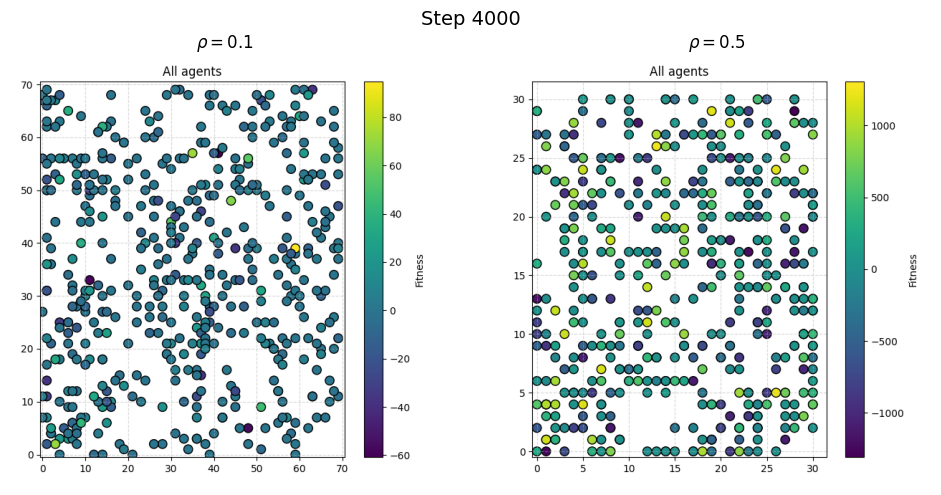

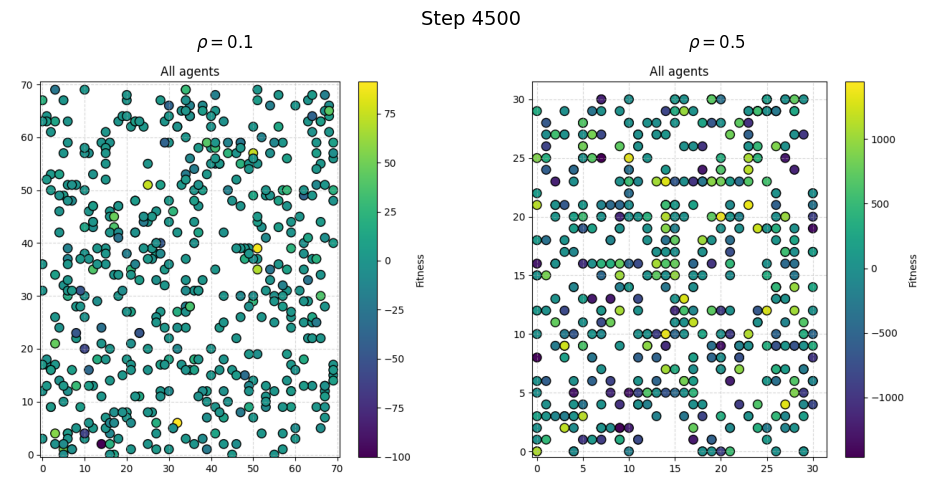

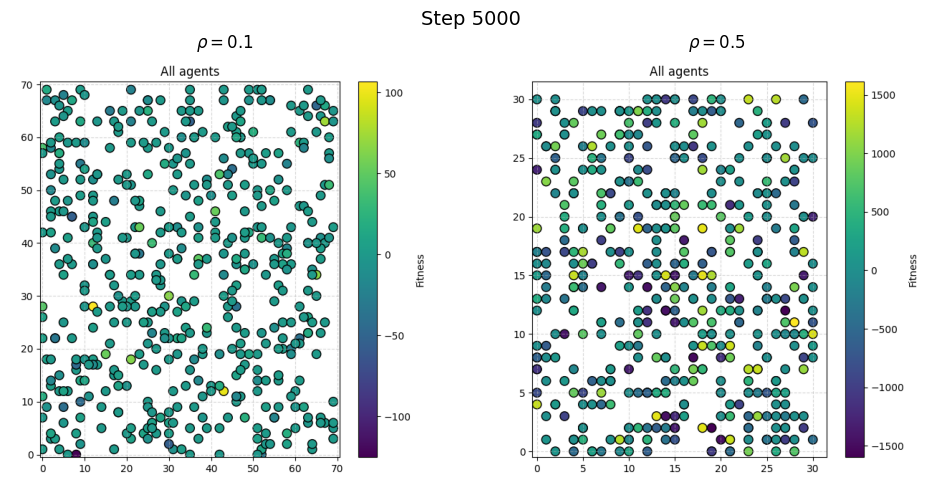

In [34]:
## Final plots
input_folder = "interactions/plots_grid"
output_folder = "interactions/plots_grid_comparison"
os.makedirs(output_folder, exist_ok=True)

steps = list(range(0, 5001, 500))
rhos = [0.1, 0.52]

for step in steps:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Step {step}", fontsize=14)

    for i, rho in enumerate(rhos):
        filename = f"step_{step}_rho_{rho}.png"
        path = os.path.join(input_folder, filename)

        if os.path.exists(path):
            img = Image.open(path).convert("RGB") 
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"$\\rho = {np.round(rho,1)}$")
        else:
            axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
            axes[i].axis("off")

    plt.tight_layout()
    
    save_path = os.path.join(output_folder, f"comparison_step_{step}.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()


# **3- Experiments on $\rho$ and $\sigma^2/N$**


In [115]:

# def simulate_one_experiment(N, grid_size, eta, mu=0.1, t_max=5000, seed=None, rho=None):
#     if rho is not None: 
#         grid_size = int(np.sqrt(N/rho))
#     else: 
#         rho = N / (grid_size**2)


#     if seed is not None:
#         np.random.seed(seed)

#     game = Game(N=N, mu=mu, grid_size=grid_size, eta=eta, tracked_fixed=False, plot_final=False)
#     game.play_game(t_max=t_max, Pi_update_every=1)

#     sigma2_final = game.compute_sigma2()
#     sigma_final = np.sqrt(sigma2_final)
#     sigma_final /= N
#     return rho, sigma_final


In [119]:
# ## Rho to test 
# rho_values = [0.05, 0.06, 0.065, 0.07, 0.075, 0.08, 0.09, 0.1, 0.12, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.5, 0.7]

# ## Fixed params 
# N = 100
# grid_size = 50
# t_max = 1000

# ## Params to move 
# eta_1 = 5
# eta_2 = 0.05

# ## Results 1
# results_1 = Parallel(n_jobs=-1)(
#     delayed(simulate_one_experiment)(N=N, grid_size=grid_size, eta=eta_1, t_max=t_max, rho=rho)
#     for rho in tqdm.tqdm(rho_values)
# )
# rhos_1, sigma_final_all_1 = zip(*results_1)

# ## Results 2
# results_2 = Parallel(n_jobs=-1)( 
#     delayed(simulate_one_experiment)(N=N, grid_size=grid_size, eta=eta_2, t_max=t_max, rho=rho)
#     for rho in tqdm.tqdm(rho_values)
# )
# rhos_2, sigma_final_all_2 = zip(*results_2)

<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/1400468283.py:2: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(rhos_1, sigma_final_all_1, marker='x', label="$\eta = 5$", color="royalblue")
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/1400468283.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(rhos_2, sigma_final_all_2, marker='x', label="$\eta = 0.05$", color="indianred")


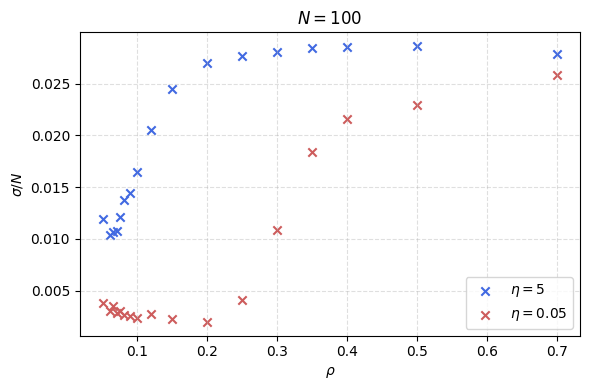

In [118]:
# plt.figure(figsize=(6, 4))
# plt.scatter(rhos_1, sigma_final_all_1, marker='x', label="$\eta = 5$", color="royalblue")
# plt.scatter(rhos_2, sigma_final_all_2, marker='x', label="$\eta = 0.05$", color="indianred")

# plt.xlabel(r"$\rho $")
# plt.ylabel(r"$\sigma / N$")
# plt.title("$N = 100$")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.4)
# plt.tight_layout()
# plt.show()

In [109]:
# ## Rho to test 
# rho_values = [0.05, 0.06, 0.065, 0.07, 0.075, 0.08, 0.09, 0.1, 0.12, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.5, 0.7]

# ## Fixed params 
# grid_size = 50
# eta = 5
# t_max = 2000

# ## Params to move 
# N_1 = 100
# N_2 = 1000

# ## Results 1
# results_1 = Parallel(n_jobs=-1)(
#     delayed(simulate_one_experiment)(N=N_1, grid_size=grid_size, eta=eta, t_max=t_max, rho=rho)
#     for rho in tqdm.tqdm(rho_values)
# )
# rhos_1, sigma_final_all_1 = zip(*results_1)

# ## Results 2
# results_2 = Parallel(n_jobs=-1)( 
#     delayed(simulate_one_experiment)(N=N_2, grid_size=grid_size, eta=eta, t_max=t_max, rho=rho)
#     for rho in tqdm.tqdm(rho_values)
# )
# rhos_2, sigma_final_all_2 = zip(*results_2)

In [110]:
# plt.figure(figsize=(6, 4))
# plt.scatter(rhos_1, sigma_final_all_1, marker='x', label="$N = 10$", color="royalblue")
# plt.scatter(rhos_2, sigma_final_all_2, marker='x', label="$N = 100$", color="indianred")

# plt.xlabel(r"$\rho $")
# plt.ylabel(r"$\sigma/ N$")
# plt.title("$\eta = 5$")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.4)
# plt.tight_layout()
# plt.show()

# **4- Influence of $\eta$: parameter of the temperature**

In [25]:
### Params
N = 100
mu=0.1
rho=0.5

In [26]:
def simulate_vs_eta(eta, N=N, rho=0.5, mu=mu, t_max=5000, seed=0):
    grid_size = int(np.sqrt(N / rho))
    np.random.seed(seed)
    game = Game(N=N, mu=mu, grid_size=grid_size, eta=eta, tracked_fixed=False, plot_final=False)
    game.play_game(t_max=t_max, Pi_update_every=1)
    sigma2_final = game.compute_sigma2()
    sigma_final = np.sqrt(sigma2_final) / N
    return eta, sigma_final


In [29]:
eta_values = [0, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1, 1.5, 2, 2.5, 5]
results = Parallel(n_jobs=-1)(
    delayed(simulate_vs_eta)(eta, N=N, rho=rho, seed=i)
    for i, eta in enumerate(eta_values)
)

etas, sigma_over_N = zip(*results)


Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531
Rho : 0.5102040816326531


 99%|█████████▉| 4939/5000 [00:35<00:00, 132.95it/s]

Rho : 0.5102040816326531


  1%|          | 27/5000 [00:00<00:37, 133.80it/s]s]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


 99%|█████████▉| 4969/5000 [00:36<00:00, 134.17it/s]

Rho : 0.5102040816326531


100%|██████████| 5000/5000 [00:25<00:00, 193.51it/s]


<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/2167087915.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Influence of $\eta$ on hierarchy")


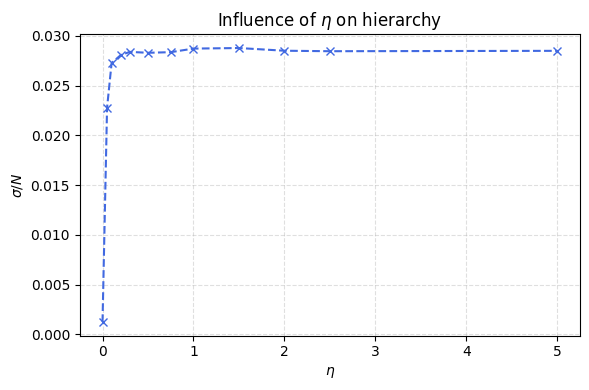

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(etas, sigma_over_N, marker='x', color="royalblue", linestyle="--")
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\sigma / N$")
plt.title("Influence of $\eta$ on hierarchy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# **5- Influence of $\mu$: relaxation parameter, agents gradually lose status if they don’t win fights**

In [46]:
def simulate_vs_mu(mu, N=100, eta=5, rho=0.1, t_max=5000, seed=0):
    grid_size = int(np.sqrt(N / rho))
    np.random.seed(seed)
    game = Game(N=N, mu=mu, grid_size=grid_size, eta=eta, tracked_fixed=False, plot_final=False)
    game.play_game(t_max=t_max, Pi_update_every=1)
    sigma2_final = game.compute_sigma2()
    sigma_final = np.sqrt(sigma2_final) / N
    return mu, sigma_final


In [47]:
mu_values = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]

results = Parallel(n_jobs=-1)(
    delayed(simulate_vs_mu)(mu, seed=i)
    for i, mu in enumerate(mu_values)
)

mus, sigma_final_all = zip(*results)

Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743
Rho : 0.1040582726326743


100%|██████████| 5000/5000 [00:34<00:00, 144.47it/s]


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/3874712635.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Impact of relaxation $\mu$ on social hierarchy")


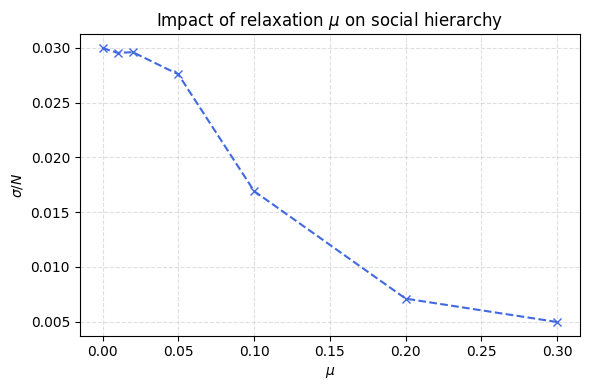

In [48]:
plt.figure(figsize=(6, 4))
plt.plot(mus, sigma_final_all, marker='x', color="royalblue", linestyle="--")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma/ N$")
plt.title("Impact of relaxation $\mu$ on social hierarchy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# **6- Phase diagram $(\eta, \rho)$**

In [162]:
eta_values = np.linspace(0.1, 5, 30)  # Fight determinism
rho_values = np.linspace(0.01, 0.6, 30)  # Agent density

In [163]:
def simulate_eta_rho(eta, rho, N=100, mu=0.1, t_max=2000, seed=0):
    grid_size = int(np.sqrt(N / rho))
    np.random.seed(seed)
    game = Game(N=N, mu=mu, grid_size=grid_size, eta=eta, tracked_fixed=False, plot_final=False)
    game.play_game(t_max=t_max, Pi_update_every=1)
    sigma2_final = game.compute_sigma2()
    sigma_final = np.sqrt(sigma2_final) / N
    return sigma_final

In [164]:
# Grid search over (rho, eta)
results = Parallel(n_jobs=-1)(
    delayed(simulate_eta_rho)(eta, rho, seed=42)
    for rho in rho_values for eta in eta_values
)

Z_1 = np.array(results).reshape(len(rho_values), len(eta_values))  # shape: (len(ρ), len(η))


Rho : 0.01
Rho : 0.01
Rho : 0.01
Rho : 0.01
Rho : 0.01
Rho : 0.01
Rho : 0.01


  1%|          | 14/2000 [00:00<00:41, 48.32it/s]

Rho : 0.01


 97%|█████████▋| 1943/2000 [00:31<00:01, 55.59it/s]

Rho : 0.01
Rho : 0.01


100%|█████████▉| 1999/2000 [00:31<00:00, 60.98it/s]

Rho : 0.01
Rho : 0.01


  0%|          | 0/2000 [00:00<?, ?it/s]1.33it/s]s]

Rho : 0.01
Rho : 0.01


  4%|▍         | 76/2000 [00:01<00:25, 74.82it/s]s]

Rho : 0.01


  5%|▍         | 96/2000 [00:01<00:27, 68.40it/s]]

Rho : 0.01


100%|█████████▉| 1993/2000 [00:30<00:00, 59.47it/s]

Rho : 0.01
Rho : 0.01
Rho : 0.01


  1%|▏         | 27/2000 [00:00<00:24, 81.42it/s]s]

Rho : 0.01
Rho : 0.01


  1%|          | 24/2000 [00:00<00:24, 80.43it/s]s]

Rho : 0.01
Rho : 0.01


  7%|▋         | 143/2000 [00:02<00:27, 68.55it/s]

Rho : 0.01


 97%|█████████▋| 1942/2000 [00:33<00:01, 50.19it/s]

Rho : 0.01
Rho : 0.01


 98%|█████████▊| 1950/2000 [00:33<00:01, 44.18it/s]

Rho : 0.01


100%|██████████| 2000/2000 [00:34<00:00, 57.74it/s]


Rho : 0.01
Rho : 0.01


  4%|▍         | 83/2000 [00:01<00:23, 80.15it/s]]]

Rho : 0.01
Rho : 0.030778701138811943


  5%|▍         | 92/2000 [00:01<00:27, 70.48it/s]]]

Rho : 0.030778701138811943


  0%|          | 10/2000 [00:00<00:20, 95.85it/s]s]

Rho : 0.030778701138811943


 72%|███████▏  | 1448/2000 [00:22<00:11, 47.72it/s]

Rho : 0.030778701138811943


 49%|████▉     | 982/2000 [00:11<00:12, 79.31it/s]s]

Rho : 0.030778701138811943


  3%|▎         | 64/2000 [00:00<00:24, 77.83it/s]s]

Rho : 0.030778701138811943
Rho : 0.030778701138811943


100%|█████████▉| 1998/2000 [00:34<00:00, 57.55it/s] 

Rho : 0.030778701138811943
Rho : 0.030778701138811943


  1%|          | 12/2000 [00:00<00:17, 115.61it/s]] 

Rho : 0.030778701138811943


 46%|████▌     | 921/2000 [00:08<00:09, 115.72it/s]]

Rho : 0.030778701138811943


 52%|█████▏    | 1043/2000 [00:10<00:08, 111.39it/s]

Rho : 0.030778701138811943


 57%|█████▋    | 1135/2000 [00:10<00:09, 89.72it/s] 

Rho : 0.030778701138811943


  1%|          | 12/2000 [00:00<00:17, 116.84it/s]]]

Rho : 0.030778701138811943


 93%|█████████▎| 1859/2000 [00:19<00:01, 106.73it/s]

Rho : 0.030778701138811943


  0%|          | 0/2000 [00:00<?, ?it/s] 89.56it/s]

Rho : 0.030778701138811943


 98%|█████████▊| 1961/2000 [00:20<00:00, 73.43it/s]

Rho : 0.030778701138811943


 69%|██████▊   | 1374/2000 [00:13<00:07, 86.43it/s]

Rho : 0.030778701138811943


 46%|████▋     | 926/2000 [00:09<00:11, 90.62it/s] 

Rho : 0.030778701138811943


 56%|█████▌    | 1114/2000 [00:11<00:07, 113.55it/s]

Rho : 0.030778701138811943


 98%|█████████▊| 1965/2000 [00:20<00:00, 92.55it/s]]

Rho : 0.030778701138811943


 59%|█████▉    | 1177/2000 [00:12<00:10, 77.90it/s]

Rho : 0.030778701138811943
Rho : 0.030778701138811943


 97%|█████████▋| 1940/2000 [00:20<00:00, 86.64it/s]

Rho : 0.030778701138811943


  8%|▊         | 166/2000 [00:01<00:18, 100.52it/s]

Rho : 0.030778701138811943


 11%|█         | 212/2000 [00:02<00:18, 96.86it/s]]

Rho : 0.030778701138811943


 88%|████████▊ | 1754/2000 [00:20<00:02, 84.60it/s]

Rho : 0.030778701138811943


  1%|          | 22/2000 [00:00<00:22, 87.92it/s] ]

Rho : 0.030778701138811943


  0%|          | 0/2000 [00:00<?, ?it/s] 87.69it/s] 

Rho : 0.030778701138811943


 97%|█████████▋| 1941/2000 [00:22<00:00, 70.72it/s] 

Rho : 0.030778701138811943


 95%|█████████▍| 1892/2000 [00:22<00:01, 77.27it/s]

Rho : 0.05165289256198347


  7%|▋         | 146/2000 [00:01<00:20, 92.28it/s] 

Rho : 0.05165289256198347


  6%|▌         | 119/2000 [00:01<00:17, 105.77it/s]

Rho : 0.05165289256198347


 52%|█████▎    | 1050/2000 [00:11<00:10, 91.63it/s]

Rho : 0.05165289256198347


 51%|█████     | 1015/2000 [00:10<00:11, 84.35it/s]

Rho : 0.05165289256198347


 61%|██████    | 1211/2000 [00:11<00:06, 117.40it/s]

Rho : 0.05165289256198347


 33%|███▎      | 665/2000 [00:06<00:13, 100.66it/s]]

Rho : 0.05165289256198347


 96%|█████████▌| 1911/2000 [00:20<00:01, 83.30it/s] 

Rho : 0.05165289256198347


  5%|▌         | 105/2000 [00:00<00:18, 103.51it/s] 

Rho : 0.05165289256198347


  3%|▎         | 60/2000 [00:00<00:18, 102.58it/s]]]

Rho : 0.05165289256198347
Rho : 0.05165289256198347


 45%|████▍     | 897/2000 [00:09<00:18, 60.37it/s]]

Rho : 0.05165289256198347


 55%|█████▌    | 1106/2000 [00:10<00:08, 109.84it/s]

Rho : 0.05165289256198347


 20%|██        | 407/2000 [00:03<00:14, 106.76it/s]]

Rho : 0.05165289256198347


 97%|█████████▋| 1933/2000 [00:18<00:00, 100.97it/s]

Rho : 0.05165289256198347


 50%|█████     | 1005/2000 [00:09<00:09, 102.89it/s]

Rho : 0.05165289256198347


 35%|███▌      | 705/2000 [00:06<00:10, 118.24it/s]]

Rho : 0.05165289256198347


 98%|█████████▊| 1960/2000 [00:18<00:00, 103.30it/s]

Rho : 0.05165289256198347
Rho : 0.05165289256198347


 40%|███▉      | 797/2000 [00:07<00:10, 111.04it/s] 

Rho : 0.05165289256198347


 44%|████▍     | 878/2000 [00:08<00:10, 105.93it/s]]

Rho : 0.05165289256198347


 25%|██▌       | 509/2000 [00:04<00:13, 113.93it/s]]

Rho : 0.05165289256198347


 91%|█████████ | 1824/2000 [00:17<00:01, 97.05it/s]]

Rho : 0.05165289256198347


  6%|▌         | 111/2000 [00:01<00:19, 97.54it/s]]

Rho : 0.05165289256198347


100%|██████████| 2000/2000 [00:19<00:00, 103.89it/s]


Rho : 0.05165289256198347


  1%|          | 13/2000 [00:00<00:16, 116.95it/s]]]

Rho : 0.05165289256198347


 60%|█████▉    | 1199/2000 [00:10<00:06, 119.85it/s]

Rho : 0.05165289256198347


 35%|███▌      | 709/2000 [00:06<00:11, 114.42it/s]]

Rho : 0.05165289256198347


 50%|████▉     | 996/2000 [00:09<00:10, 96.14it/s] ]

Rho : 0.05165289256198347


 68%|██████▊   | 1363/2000 [00:14<00:08, 78.26it/s]

Rho : 0.05165289256198347


 93%|█████████▎| 1868/2000 [00:19<00:01, 95.75it/s] 

Rho : 0.07304601899196493


 91%|█████████ | 1821/2000 [00:19<00:01, 111.53it/s]

Rho : 0.07304601899196493


 93%|█████████▎| 1859/2000 [00:19<00:01, 96.71it/s] 

Rho : 0.07304601899196493


  0%|          | 0/2000 [00:00<?, ?it/s] 104.99it/s]

Rho : 0.07304601899196493
Rho : 0.07304601899196493


 11%|█         | 211/2000 [00:01<00:15, 118.05it/s]]

Rho : 0.07304601899196493


 50%|█████     | 1005/2000 [00:09<00:08, 116.32it/s]

Rho : 0.07304601899196493


 80%|████████  | 1608/2000 [00:13<00:03, 119.37it/s]

Rho : 0.07304601899196493


 44%|████▍     | 889/2000 [00:07<00:09, 119.17it/s]]

Rho : 0.07304601899196493


 90%|████████▉ | 1796/2000 [00:16<00:02, 99.59it/s] 

Rho : 0.07304601899196493
Rho : 0.07304601899196493


 12%|█▏        | 239/2000 [00:01<00:13, 132.67it/s]]

Rho : 0.07304601899196493
Rho : 0.07304601899196493


 66%|██████▌   | 1315/2000 [00:10<00:05, 132.42it/s]

Rho : 0.07304601899196493


 51%|█████▏    | 1027/2000 [00:08<00:07, 130.53it/s]

Rho : 0.07304601899196493


 95%|█████████▌| 1901/2000 [00:15<00:00, 118.57it/s]

Rho : 0.07304601899196493


  0%|          | 0/2000 [00:00<?, ?it/s] 119.79it/s]

Rho : 0.07304601899196493


  1%|          | 18/2000 [00:00<00:11, 179.45it/s]s]

Rho : 0.07304601899196493
Rho : 0.07304601899196493


  2%|▎         | 50/2000 [00:00<00:16, 117.09it/s]]]

Rho : 0.07304601899196493
Rho : 0.07304601899196493


  1%|          | 13/2000 [00:00<00:15, 125.72it/s]]]

Rho : 0.07304601899196493


 63%|██████▎   | 1268/2000 [00:10<00:06, 106.67it/s]

Rho : 0.07304601899196493


 89%|████████▉ | 1789/2000 [00:17<00:02, 83.18it/s] 

Rho : 0.07304601899196493


 93%|█████████▎| 1861/2000 [00:17<00:01, 111.32it/s]

Rho : 0.07304601899196493


  0%|          | 0/2000 [00:00<?, ?it/s]19.94it/s]]]

Rho : 0.07304601899196493
Rho : 0.07304601899196493


 50%|████▉     | 997/2000 [00:10<00:09, 106.12it/s]]

Rho : 0.07304601899196493


 13%|█▎        | 269/2000 [00:02<00:14, 118.57it/s] 

Rho : 0.07304601899196493


 18%|█▊        | 361/2000 [00:02<00:14, 116.00it/s]]

Rho : 0.07304601899196493


 52%|█████▏    | 1031/2000 [00:08<00:07, 129.17it/s]

Rho : 0.09182736455463728


 86%|████████▋ | 1726/2000 [00:14<00:02, 113.39it/s]

Rho : 0.09182736455463728


 89%|████████▉ | 1780/2000 [00:14<00:01, 123.81it/s]

Rho : 0.09182736455463728


  0%|          | 0/2000 [00:00<?, ?it/s] 118.09it/s]

Rho : 0.09182736455463728
Rho : 0.09182736455463728
Rho : 0.09182736455463728


  1%|          | 15/2000 [00:00<00:13, 147.73it/s]s]

Rho : 0.09182736455463728


 27%|██▋       | 549/2000 [00:04<00:12, 118.82it/s]]

Rho : 0.09182736455463728


 30%|███       | 609/2000 [00:04<00:12, 113.99it/s]]

Rho : 0.09182736455463728


 90%|████████▉ | 1799/2000 [00:13<00:01, 122.71it/s]

Rho : 0.09182736455463728


  6%|▌         | 114/2000 [00:00<00:14, 132.90it/s]]

Rho : 0.09182736455463728


  9%|▊         | 173/2000 [00:01<00:13, 135.69it/s]]

Rho : 0.09182736455463728


  7%|▋         | 141/2000 [00:01<00:14, 124.14it/s]]

Rho : 0.09182736455463728
Rho : 0.09182736455463728
Rho : 0.09182736455463728


  1%|          | 15/2000 [00:00<00:13, 144.24it/s]]]

Rho : 0.09182736455463728


 46%|████▌     | 915/2000 [00:08<00:12, 84.13it/s]s]

Rho : 0.09182736455463728


 98%|█████████▊| 1967/2000 [00:17<00:00, 118.76it/s]

Rho : 0.09182736455463728


 45%|████▍     | 891/2000 [00:08<00:10, 101.31it/s]]

Rho : 0.09182736455463728


  7%|▋         | 141/2000 [00:01<00:18, 100.05it/s]]

Rho : 0.09182736455463728
Rho : 0.09182736455463728


 80%|████████  | 1606/2000 [00:14<00:03, 105.50it/s]

Rho : 0.09182736455463728


 10%|▉         | 199/2000 [00:01<00:17, 100.60it/s]

Rho : 0.09182736455463728


 21%|██        | 420/2000 [00:03<00:11, 135.05it/s]]

Rho : 0.09182736455463728


 51%|█████▏    | 1027/2000 [00:09<00:09, 105.49it/s]

Rho : 0.09182736455463728


  0%|          | 0/2000 [00:00<?, ?it/s] 107.95it/s]

Rho : 0.09182736455463728


 44%|████▍     | 875/2000 [00:08<00:10, 109.23it/s]]

Rho : 0.09182736455463728


 92%|█████████▏| 1848/2000 [00:17<00:01, 93.90it/s] 

Rho : 0.09182736455463728


  1%|          | 12/2000 [00:00<00:16, 117.73it/s]] 

Rho : 0.09182736455463728
Rho : 0.09182736455463728


 13%|█▎        | 253/2000 [00:02<00:14, 122.42it/s]]

Rho : 0.11890606420927467


 28%|██▊       | 570/2000 [00:04<00:09, 144.50it/s]]

Rho : 0.11890606420927467


 49%|████▊     | 971/2000 [00:08<00:09, 110.76it/s]]

Rho : 0.11890606420927467


  0%|          | 0/2000 [00:00<?, ?it/s] 124.33it/s]

Rho : 0.11890606420927467


 97%|█████████▋| 1948/2000 [00:17<00:00, 118.85it/s]

Rho : 0.11890606420927467
Rho : 0.11890606420927467


 98%|█████████▊| 1970/2000 [00:17<00:00, 99.14it/s] 

Rho : 0.11890606420927467


 51%|█████     | 1022/2000 [00:08<00:07, 128.33it/s]

Rho : 0.11890606420927467


  6%|▌         | 117/2000 [00:01<00:20, 90.08it/s]]

Rho : 0.11890606420927467


 33%|███▎      | 653/2000 [00:06<00:14, 90.85it/s]]

Rho : 0.11890606420927467


 56%|█████▋    | 1126/2000 [00:10<00:07, 109.41it/s]

Rho : 0.11890606420927467


100%|██████████| 2000/2000 [00:19<00:00, 104.57it/s]


Rho : 0.11890606420927467
Rho : 0.11890606420927467
Rho : 0.11890606420927467


  1%|          | 24/2000 [00:00<00:16, 116.91it/s]s]

Rho : 0.11890606420927467


 51%|█████     | 1019/2000 [00:08<00:08, 118.64it/s]

Rho : 0.11890606420927467
Rho : 0.11890606420927467


  1%|          | 11/2000 [00:00<00:18, 109.20it/s]]]

Rho : 0.11890606420927467


 56%|█████▌    | 1124/2000 [00:09<00:07, 111.91it/s]

Rho : 0.11890606420927467


  1%|          | 23/2000 [00:00<00:17, 113.44it/s]s]

Rho : 0.11890606420927467
Rho : 0.11890606420927467


  2%|▏         | 42/2000 [00:00<00:17, 112.27it/s]]]

Rho : 0.11890606420927467
Rho : 0.11890606420927467


100%|█████████▉| 1993/2000 [00:18<00:00, 127.03it/s]

Rho : 0.11890606420927467
Rho : 0.11890606420927467


 30%|██▉       | 596/2000 [00:05<00:11, 121.54it/s]]

Rho : 0.11890606420927467


 57%|█████▋    | 1140/2000 [00:10<00:10, 84.85it/s]]

Rho : 0.11890606420927467


 99%|█████████▉| 1978/2000 [00:18<00:00, 114.44it/s]

Rho : 0.11890606420927467


  2%|▏         | 41/2000 [00:00<00:16, 116.60it/s]]

Rho : 0.11890606420927467


 94%|█████████▍| 1890/2000 [00:17<00:01, 93.67it/s] 

Rho : 0.11890606420927467
Rho : 0.13717421124828533


  1%|          | 15/2000 [00:00<00:13, 149.67it/s]s]

Rho : 0.13717421124828533
Rho : 0.13717421124828533


 25%|██▍       | 497/2000 [00:04<00:11, 129.98it/s]]

Rho : 0.13717421124828533


 24%|██▍       | 486/2000 [00:04<00:14, 103.48it/s]]

Rho : 0.13717421124828533


 67%|██████▋   | 1346/2000 [00:11<00:05, 124.23it/s]

Rho : 0.13717421124828533


 71%|███████▏  | 1426/2000 [00:12<00:04, 119.67it/s]

Rho : 0.13717421124828533
Rho : 0.13717421124828533


  0%|          | 0/2000 [00:00<?, ?it/s]139.48it/s]]

Rho : 0.13717421124828533
Rho : 0.13717421124828533


  0%|          | 0/2000 [00:00<?, ?it/s]18.42it/s]s]

Rho : 0.13717421124828533


 27%|██▋       | 533/2000 [00:04<00:11, 123.44it/s]]

Rho : 0.13717421124828533


 49%|████▉     | 977/2000 [00:08<00:09, 107.03it/s]]

Rho : 0.13717421124828533


 87%|████████▋ | 1732/2000 [00:14<00:03, 81.39it/s]]

Rho : 0.13717421124828533


  0%|          | 0/2000 [00:00<?, ?it/s]105.64it/s]]

Rho : 0.13717421124828533
Rho : 0.13717421124828533


 96%|█████████▋| 1930/2000 [00:18<00:00, 75.37it/s]

Rho : 0.13717421124828533


  0%|          | 9/2000 [00:00<00:22, 89.66it/s]]]]

Rho : 0.13717421124828533


 85%|████████▍ | 1691/2000 [00:15<00:02, 103.31it/s]

Rho : 0.13717421124828533


 23%|██▎       | 468/2000 [00:04<00:14, 105.15it/s]

Rho : 0.13717421124828533


 31%|███▏      | 628/2000 [00:08<00:12, 106.12it/s]]

Rho : 0.13717421124828533


 92%|█████████▎| 1850/2000 [00:21<00:01, 96.11it/s] 

Rho : 0.13717421124828533


 42%|████▏     | 842/2000 [00:08<00:12, 89.09it/s]  

Rho : 0.13717421124828533


  0%|          | 0/2000 [00:00<?, ?it/s] 98.38it/s]]

Rho : 0.13717421124828533


 92%|█████████▏| 1841/2000 [00:21<00:01, 94.97it/s] 

Rho : 0.13717421124828533


 82%|████████▏ | 1643/2000 [00:18<00:03, 106.80it/s]

Rho : 0.13717421124828533


  1%|▏         | 25/2000 [00:00<00:16, 120.04it/s]]]

Rho : 0.13717421124828533


 19%|█▉        | 385/2000 [00:03<00:17, 94.87it/s]]]

Rho : 0.13717421124828533


 24%|██▍       | 485/2000 [00:04<00:12, 121.33it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 68%|██████▊   | 1358/2000 [00:12<00:05, 113.27it/s]

Rho : 0.13717421124828533


  1%|          | 14/2000 [00:00<00:14, 134.39it/s]s]

Rho : 0.13717421124828533


 10%|█         | 201/2000 [00:01<00:15, 114.89it/s]]

Rho : 0.16
Rho : 0.16


  9%|▉         | 187/2000 [00:01<00:14, 121.60it/s]]

Rho : 0.16


  0%|          | 0/2000 [00:00<?, ?it/s]111.49it/s]]

Rho : 0.16
Rho : 0.16


  1%|          | 14/2000 [00:00<00:15, 131.44it/s]]]

Rho : 0.16


 48%|████▊     | 959/2000 [00:08<00:09, 106.91it/s]]

Rho : 0.16


 82%|████████▏ | 1642/2000 [00:13<00:02, 121.76it/s]

Rho : 0.16


 39%|███▉      | 784/2000 [00:06<00:09, 127.62it/s]]

Rho : 0.16


 41%|████      | 812/2000 [00:06<00:09, 127.82it/s]]

Rho : 0.16


  9%|▊         | 173/2000 [00:01<00:15, 120.10it/s]]

Rho : 0.16


 53%|█████▎    | 1054/2000 [00:08<00:07, 126.13it/s]

Rho : 0.16


 91%|█████████▏| 1827/2000 [00:15<00:01, 126.80it/s]

Rho : 0.16


  1%|          | 14/2000 [00:00<00:15, 130.76it/s]]]

Rho : 0.16


 61%|██████    | 1219/2000 [00:10<00:06, 114.09it/s]

Rho : 0.16


 93%|█████████▎| 1857/2000 [00:15<00:01, 116.29it/s]

Rho : 0.16


 38%|███▊      | 758/2000 [00:06<00:10, 116.99it/s]]

Rho : 0.16


  2%|▏         | 30/2000 [00:00<00:14, 137.91it/s]]]

Rho : 0.16


 18%|█▊        | 351/2000 [00:03<00:13, 122.90it/s] 

Rho : 0.16
Rho : 0.16


 59%|█████▉    | 1187/2000 [00:10<00:07, 107.24it/s]

Rho : 0.16


 20%|██        | 406/2000 [00:03<00:14, 107.33it/s]]

Rho : 0.16


  1%|          | 13/2000 [00:00<00:16, 121.76it/s]] 

Rho : 0.16


 72%|███████▏  | 1430/2000 [00:12<00:04, 135.66it/s]

Rho : 0.16


 91%|█████████ | 1819/2000 [00:15<00:01, 115.37it/s]

Rho : 0.16


 76%|███████▌  | 1514/2000 [00:12<00:04, 112.48it/s]

Rho : 0.16


 19%|█▉        | 378/2000 [00:03<00:13, 122.60it/s]]

Rho : 0.16


 22%|██▏       | 439/2000 [00:03<00:11, 138.24it/s]]

Rho : 0.16


  0%|          | 0/2000 [00:00<?, ?it/s]114.77it/s]]

Rho : 0.16


  6%|▌         | 111/2000 [00:00<00:13, 140.52it/s]]

Rho : 0.16


 37%|███▋      | 733/2000 [00:06<00:11, 111.42it/s]]

Rho : 0.1736111111111111


 86%|████████▌ | 1712/2000 [00:15<00:02, 135.81it/s]

Rho : 0.1736111111111111


 77%|███████▋  | 1533/2000 [00:13<00:05, 86.67it/s]]

Rho : 0.1736111111111111


 83%|████████▎ | 1659/2000 [00:15<00:03, 106.29it/s]

Rho : 0.1736111111111111


  0%|          | 0/2000 [00:00<?, ?it/s]103.92it/s]]

Rho : 0.1736111111111111
Rho : 0.1736111111111111


 19%|█▉        | 382/2000 [00:03<00:15, 105.44it/s]]

Rho : 0.1736111111111111


 66%|██████▌   | 1319/2000 [00:12<00:05, 117.66it/s]

Rho : 0.1736111111111111


 63%|██████▎   | 1265/2000 [00:12<00:06, 111.90it/s]

Rho : 0.1736111111111111


 65%|██████▍   | 1293/2000 [00:12<00:09, 75.02it/s]

Rho : 0.1736111111111111


 88%|████████▊ | 1770/2000 [00:17<00:02, 92.79it/s] 

Rho : 0.1736111111111111


  1%|          | 13/2000 [00:00<00:16, 121.46it/s]]]

Rho : 0.1736111111111111


 12%|█▏        | 241/2000 [00:02<00:15, 110.88it/s]]

Rho : 0.1736111111111111


 52%|█████▏    | 1032/2000 [00:10<00:10, 95.57it/s] 

Rho : 0.1736111111111111


 96%|█████████▌| 1923/2000 [00:19<00:00, 106.18it/s]

Rho : 0.1736111111111111


 19%|█▉        | 385/2000 [00:03<00:15, 105.61it/s]]

Rho : 0.1736111111111111


 35%|███▍      | 699/2000 [00:06<00:11, 115.93it/s]]

Rho : 0.1736111111111111


 81%|████████  | 1618/2000 [00:14<00:03, 110.34it/s]

Rho : 0.1736111111111111


 38%|███▊      | 758/2000 [00:06<00:12, 98.61it/s]s]

Rho : 0.1736111111111111


 14%|█▍        | 279/2000 [00:02<00:15, 108.99it/s]

Rho : 0.1736111111111111


 83%|████████▎ | 1668/2000 [00:14<00:03, 96.15it/s]

Rho : 0.1736111111111111
Rho : 0.1736111111111111


 18%|█▊        | 355/2000 [00:03<00:15, 105.06it/s]]

Rho : 0.1736111111111111
Rho : 0.1736111111111111


 34%|███▎      | 671/2000 [00:05<00:09, 137.00it/s]]

Rho : 0.1736111111111111


  1%|▏         | 25/2000 [00:00<00:16, 122.75it/s]s]

Rho : 0.1736111111111111


  0%|          | 0/2000 [00:00<?, ?it/s] 116.97it/s]

Rho : 0.1736111111111111


 41%|████      | 818/2000 [00:06<00:10, 113.30it/s]]

Rho : 0.1736111111111111


  9%|▉         | 185/2000 [00:01<00:15, 115.60it/s]]

Rho : 0.1736111111111111
Rho : 0.1736111111111111


 15%|█▍        | 297/2000 [00:02<00:19, 89.38it/s] ]

Rho : 0.2066115702479339


 21%|██        | 412/2000 [00:03<00:13, 119.16it/s]]

Rho : 0.2066115702479339


 55%|█████▍    | 1093/2000 [00:10<00:05, 159.63it/s]

Rho : 0.2066115702479339


 78%|███████▊  | 1568/2000 [00:14<00:03, 109.57it/s]

Rho : 0.2066115702479339


 71%|███████   | 1414/2000 [00:14<00:06, 92.56it/s]]

Rho : 0.2066115702479339


 88%|████████▊ | 1770/2000 [00:17<00:02, 96.71it/s]]

Rho : 0.2066115702479339


 47%|████▋     | 942/2000 [00:08<00:09, 116.72it/s]]

Rho : 0.2066115702479339


 15%|█▍        | 294/2000 [00:02<00:18, 90.77it/s] ]

Rho : 0.2066115702479339


 43%|████▎     | 855/2000 [00:08<00:10, 112.82it/s]]

Rho : 0.2066115702479339


 23%|██▎       | 458/2000 [00:04<00:12, 118.68it/s]]

Rho : 0.2066115702479339


 44%|████▍     | 881/2000 [00:08<00:10, 106.27it/s]]

Rho : 0.2066115702479339


 84%|████████▍ | 1677/2000 [00:15<00:03, 83.66it/s]]

Rho : 0.2066115702479339


 40%|████      | 801/2000 [00:07<00:10, 111.08it/s]]

Rho : 0.2066115702479339


 21%|██        | 411/2000 [00:03<00:14, 105.94it/s]]

Rho : 0.2066115702479339


 44%|████▎     | 870/2000 [00:08<00:10, 104.48it/s]]

Rho : 0.2066115702479339


 86%|████████▌ | 1718/2000 [00:16<00:02, 112.15it/s]

Rho : 0.2066115702479339


 98%|█████████▊| 1969/2000 [00:18<00:00, 104.16it/s]

Rho : 0.2066115702479339


 33%|███▎      | 664/2000 [00:06<00:10, 122.40it/s]]

Rho : 0.2066115702479339


 30%|██▉       | 594/2000 [00:05<00:12, 108.85it/s]]

Rho : 0.2066115702479339


 73%|███████▎  | 1466/2000 [00:13<00:05, 99.59it/s] /var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 54%|█████▍    | 1086/2000 [00:09<00:10, 89.60it/s]]

Rho : 0.2066115702479339


 92%|█████████▏| 1846/2000 [00:17<00:01, 111.75it/s]

Rho : 0.2066115702479339


 95%|█████████▌| 1905/2000 [00:18<00:00, 140.58it/s]

Rho : 0.2066115702479339


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 76%|███████▌  | 1512/2000 [00:14<00:05, 92.38it/s] 

Rho : 0.2066115702479339


 87%|████████▋ | 1745/2000 [00:16<00:02, 90.50it/s]

Rho : 0.2066115702479339


  0%|          | 0/2000 [00:00<?, ?it/s] 88.47it/s]

Rho : 0.2066115702479339


  0%|          | 3/2000 [00:00<01:07, 29.77it/s]s]]

Rho : 0.2066115702479339


 48%|████▊     | 960/2000 [00:09<00:08, 117.37it/s]]

Rho : 0.2066115702479339


  1%|          | 15/2000 [00:00<00:14, 139.04it/s]]]

Rho : 0.2066115702479339


  0%|          | 10/2000 [00:00<00:21, 92.81it/s]]  

Rho : 0.2066115702479339


 99%|█████████▉| 1984/2000 [00:18<00:00, 91.99it/s]]

Rho : 0.2066115702479339


  0%|          | 0/2000 [00:00<?, ?it/s] 108.23it/s]

Rho : 0.22675736961451248


 87%|████████▋ | 1731/2000 [00:15<00:02, 101.96it/s]

Rho : 0.22675736961451248


 51%|█████     | 1023/2000 [00:09<00:08, 116.82it/s]

Rho : 0.22675736961451248


 38%|███▊      | 760/2000 [00:07<00:10, 121.22it/s] 

Rho : 0.22675736961451248


  0%|          | 0/2000 [00:00<?, ?it/s]113.06it/s]]

Rho : 0.22675736961451248


 48%|████▊     | 970/2000 [00:09<00:09, 114.12it/s]]

Rho : 0.22675736961451248


 19%|█▊        | 371/2000 [00:04<00:20, 77.58it/s]] 

Rho : 0.22675736961451248


 68%|██████▊   | 1355/2000 [00:13<00:09, 67.49it/s]]

Rho : 0.22675736961451248


  3%|▎         | 63/2000 [00:00<00:17, 112.34it/s]]]

Rho : 0.22675736961451248


 41%|████      | 811/2000 [00:08<00:12, 98.09it/s]]]

Rho : 0.22675736961451248


 14%|█▍        | 278/2000 [00:02<00:13, 125.57it/s]]

Rho : 0.22675736961451248


  0%|          | 0/2000 [00:00<?, ?it/s] 119.03it/s]

Rho : 0.22675736961451248


 49%|████▉     | 981/2000 [00:08<00:09, 112.44it/s]]

Rho : 0.22675736961451248


 61%|██████    | 1216/2000 [00:10<00:07, 111.28it/s]

Rho : 0.22675736961451248


 77%|███████▋  | 1535/2000 [00:12<00:04, 111.96it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 19%|█▉        | 383/2000 [00:03<00:15, 106.70it/s]]

Rho : 0.22675736961451248


 75%|███████▍  | 1495/2000 [00:11<00:03, 130.78it/s]

Rho : 0.22675736961451248


 12%|█▏        | 233/2000 [00:01<00:12, 139.68it/s]]

Rho : 0.22675736961451248


  0%|          | 0/2000 [00:00<?, ?it/s] 103.30it/s]

Rho : 0.22675736961451248


 64%|██████▎   | 1271/2000 [00:10<00:06, 114.65it/s]

Rho : 0.22675736961451248


  8%|▊         | 154/2000 [00:01<00:17, 106.55it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
  1%|          | 11/2000 [00:00<00:18, 104.98it/s]]]

Rho : 0.22675736961451248


  0%|          | 0/2000 [00:00<?, ?it/s] 155.94it/s]

Rho : 0.22675736961451248


 75%|███████▍  | 1491/2000 [00:12<00:03, 130.28it/s]

Rho : 0.22675736961451248


 69%|██████▉   | 1387/2000 [00:12<00:05, 116.71it/s]

Rho : 0.22675736961451248
Rho : 0.22675736961451248


 69%|██████▉   | 1384/2000 [00:11<00:05, 116.13it/s]

Rho : 0.22675736961451248


 50%|████▉     | 998/2000 [00:08<00:08, 116.80it/s]]

Rho : 0.22675736961451248


 23%|██▎       | 459/2000 [00:03<00:11, 128.52it/s]]

Rho : 0.22675736961451248


 61%|██████    | 1224/2000 [00:10<00:06, 129.18it/s]

Rho : 0.22675736961451248


 72%|███████▏  | 1437/2000 [00:11<00:04, 123.07it/s]

Rho : 0.22675736961451248


  1%|          | 15/2000 [00:00<00:13, 142.14it/s]s]

Rho : 0.22675736961451248


 24%|██▍       | 487/2000 [00:04<00:12, 122.89it/s]]

Rho : 0.25


  0%|          | 0/2000 [00:00<?, ?it/s]117.36it/s]

Rho : 0.25


 12%|█▏        | 233/2000 [00:01<00:12, 136.69it/s]]

Rho : 0.25


 91%|█████████ | 1811/2000 [00:14<00:01, 123.95it/s]

Rho : 0.25


 86%|████████▌ | 1711/2000 [00:14<00:02, 98.68it/s]]

Rho : 0.25


  1%|          | 12/2000 [00:00<00:17, 114.93it/s]]]

Rho : 0.25


 42%|████▏     | 835/2000 [00:07<00:10, 107.36it/s]]

Rho : 0.25


 88%|████████▊ | 1763/2000 [00:14<00:02, 108.22it/s]

Rho : 0.25


 67%|██████▋   | 1338/2000 [00:11<00:06, 103.89it/s]

Rho : 0.25
Rho : 0.25


 25%|██▌       | 506/2000 [00:04<00:14, 105.02it/s] 

Rho : 0.25


 38%|███▊      | 755/2000 [00:06<00:09, 128.28it/s]]

Rho : 0.25


 62%|██████▏   | 1249/2000 [00:10<00:06, 123.95it/s]

Rho : 0.25


 26%|██▌       | 510/2000 [00:04<00:11, 130.33it/s]]

Rho : 0.25


  1%|          | 12/2000 [00:00<00:17, 111.60it/s]s]

Rho : 0.25


 63%|██████▎   | 1258/2000 [00:10<00:05, 134.00it/s]

Rho : 0.25


 25%|██▌       | 500/2000 [00:03<00:11, 128.08it/s]]

Rho : 0.25


 53%|█████▎    | 1051/2000 [00:08<00:07, 124.00it/s]

Rho : 0.25


 37%|███▋      | 746/2000 [00:06<00:10, 118.58it/s]]

Rho : 0.25


 90%|█████████ | 1810/2000 [00:14<00:02, 90.80it/s] 

Rho : 0.25


  0%|          | 0/2000 [00:00<?, ?it/s]112.14it/s]]

Rho : 0.25


 50%|████▉     | 997/2000 [00:08<00:07, 131.85it/s]]

Rho : 0.25


 80%|███████▉  | 1597/2000 [00:12<00:03, 110.78it/s]

Rho : 0.25


 93%|█████████▎| 1869/2000 [00:15<00:01, 111.85it/s]

Rho : 0.25


 43%|████▎     | 867/2000 [00:07<00:10, 104.87it/s]]

Rho : 0.25


 15%|█▍        | 296/2000 [00:02<00:14, 114.11it/s]]

Rho : 0.25


 60%|██████    | 1207/2000 [00:10<00:06, 118.51it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp


Rho : 0.25


 72%|███████▏  | 1448/2000 [00:12<00:04, 129.34it/s]

Rho : 0.25


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
  1%|          | 20/2000 [00:00<00:10, 193.10it/s]]]

Rho : 0.25


 62%|██████▏   | 1231/2000 [00:09<00:05, 150.74it/s]

Rho : 0.25


100%|██████████| 2000/2000 [00:16<00:00, 121.50it/s]
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 89%|████████▊ | 1774/2000 [00:13<00:01, 125.33it/s]

Rho : 0.2770083102493075


  0%|          | 0/2000 [00:00<?, ?it/s] 123.42it/s]

Rho : 0.2770083102493075


 78%|███████▊  | 1560/2000 [00:12<00:04, 106.18it/s]

Rho : 0.2770083102493075


 52%|█████▏    | 1033/2000 [00:08<00:07, 135.79it/s]

Rho : 0.2770083102493075


 41%|████      | 812/2000 [00:06<00:08, 136.30it/s]]

Rho : 0.2770083102493075


 72%|███████▏  | 1445/2000 [00:11<00:04, 119.44it/s]

Rho : 0.2770083102493075


 43%|████▎     | 853/2000 [00:07<00:09, 116.25it/s]]

Rho : 0.2770083102493075


 30%|███       | 607/2000 [00:05<00:10, 133.21it/s]]

Rho : 0.2770083102493075


 70%|███████   | 1404/2000 [00:11<00:05, 111.47it/s]

Rho : 0.2770083102493075


 97%|█████████▋| 1946/2000 [00:15<00:00, 122.63it/s]

Rho : 0.2770083102493075


 17%|█▋        | 339/2000 [00:02<00:13, 123.45it/s]]

Rho : 0.2770083102493075


  1%|          | 13/2000 [00:00<00:15, 127.19it/s]s]

Rho : 0.2770083102493075


 24%|██▍       | 483/2000 [00:03<00:12, 126.26it/s]]

Rho : 0.2770083102493075


 96%|█████████▌| 1910/2000 [00:15<00:00, 116.36it/s]

Rho : 0.2770083102493075


  5%|▌         | 104/2000 [00:00<00:16, 117.90it/s]]

Rho : 0.2770083102493075


 27%|██▋       | 545/2000 [00:04<00:11, 122.22it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.2770083102493075


 68%|██████▊   | 1365/2000 [00:11<00:05, 125.01it/s]

Rho : 0.2770083102493075


 14%|█▍        | 287/2000 [00:02<00:14, 122.17it/s]]

Rho : 0.2770083102493075


 34%|███▍      | 688/2000 [00:05<00:12, 108.04it/s]]

Rho : 0.2770083102493075


  0%|          | 0/2000 [00:00<?, ?it/s]102.26it/s] 

Rho : 0.2770083102493075


  1%|▏         | 28/2000 [00:00<00:14, 136.21it/s]]]

Rho : 0.2770083102493075


 51%|█████     | 1016/2000 [00:08<00:08, 122.50it/s]

Rho : 0.2770083102493075


 22%|██▏       | 436/2000 [00:03<00:12, 123.41it/s]]

Rho : 0.2770083102493075


  1%|          | 13/2000 [00:00<00:16, 121.33it/s]s]

Rho : 0.2770083102493075


 84%|████████▍ | 1690/2000 [00:14<00:03, 97.62it/s]]

Rho : 0.2770083102493075


 11%|█         | 216/2000 [00:01<00:13, 127.98it/s]]

Rho : 0.2770083102493075


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 31%|███▏      | 628/2000 [00:05<00:12, 109.05it/s]]

Rho : 0.2770083102493075


 50%|████▉     | 995/2000 [00:08<00:09, 101.54it/s]]

Rho : 0.2770083102493075
Rho : 0.2770083102493075


 42%|████▏     | 833/2000 [00:06<00:08, 133.64it/s]]

Rho : 0.2770083102493075


 51%|█████     | 1011/2000 [00:08<00:07, 129.17it/s]

Rho : 0.2770083102493075


  1%|          | 13/2000 [00:00<00:16, 117.56it/s]]]

Rho : 0.2770083102493075


 50%|████▉     | 990/2000 [00:07<00:08, 119.04it/s]]

Rho : 0.2770083102493075


  1%|          | 14/2000 [00:00<00:14, 138.86it/s]s]

Rho : 0.2770083102493075


 22%|██▏       | 430/2000 [00:03<00:12, 124.88it/s]]

Rho : 0.2770083102493075


 30%|██▉       | 597/2000 [00:04<00:09, 141.04it/s]]

Rho : 0.2770083102493075
Rho : 0.2770083102493075


 92%|█████████▏| 1846/2000 [00:15<00:01, 145.67it/s]

Rho : 0.2770083102493075


 40%|███▉      | 793/2000 [00:06<00:10, 111.58it/s]]

Rho : 0.2770083102493075


  1%|          | 13/2000 [00:00<00:16, 123.52it/s]s]

Rho : 0.2770083102493075


 61%|██████▏   | 1229/2000 [00:11<00:07, 109.90it/s]

Rho : 0.2770083102493075


 89%|████████▊ | 1772/2000 [00:15<00:02, 88.83it/s]]

Rho : 0.2770083102493075


 70%|██████▉   | 1398/2000 [00:12<00:04, 131.10it/s]

Rho : 0.2770083102493075


 27%|██▋       | 533/2000 [00:04<00:11, 126.10it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
  1%|          | 14/2000 [00:00<00:15, 132.15it/s]]]

Rho : 0.2770083102493075


 20%|██        | 404/2000 [00:03<00:13, 116.35it/s]]

Rho : 0.2770083102493075


 12%|█▏        | 236/2000 [00:02<00:16, 109.09it/s]]

Rho : 0.2770083102493075


 41%|████      | 815/2000 [00:06<00:08, 139.27it/s]]

Rho : 0.2770083102493075


 99%|█████████▊| 1973/2000 [00:16<00:00, 131.20it/s]

Rho : 0.2770083102493075


100%|██████████| 2000/2000 [00:16<00:00, 122.81it/s]
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 48%|████▊     | 962/2000 [00:07<00:08, 124.70it/s]]

Rho : 0.2770083102493075


 70%|██████▉   | 1398/2000 [00:10<00:04, 125.64it/s]

Rho : 0.2770083102493075


  0%|          | 0/2000 [00:00<?, ?it/s] 137.15it/s]

Rho : 0.2770083102493075


 41%|████      | 822/2000 [00:06<00:09, 126.41it/s]]

Rho : 0.2770083102493075


  0%|          | 6/2000 [00:00<00:35, 55.63it/s]/s]]

Rho : 0.2770083102493075


 55%|█████▌    | 1109/2000 [00:09<00:06, 140.18it/s]

Rho : 0.2770083102493075


 41%|████      | 824/2000 [00:06<00:10, 116.13it/s]]

Rho : 0.2770083102493075


100%|██████████| 2000/2000 [00:16<00:00, 118.96it/s]


Rho : 0.2770083102493075


 94%|█████████▍| 1878/2000 [00:15<00:01, 119.51it/s]

Rho : 0.2770083102493075


  7%|▋         | 140/2000 [00:01<00:17, 109.15it/s]]

Rho : 0.2770083102493075


 24%|██▎       | 470/2000 [00:04<00:14, 106.76it/s]]

Rho : 0.2770083102493075


 40%|████      | 802/2000 [00:07<00:09, 121.59it/s]]

Rho : 0.2770083102493075


 44%|████▍     | 879/2000 [00:07<00:09, 116.91it/s]]

Rho : 0.30864197530864196


 52%|█████▏    | 1046/2000 [00:09<00:07, 124.96it/s]

Rho : 0.30864197530864196


 56%|█████▌    | 1119/2000 [00:09<00:07, 114.78it/s]

Rho : 0.30864197530864196


 96%|█████████▌| 1915/2000 [00:16<00:00, 122.15it/s]

Rho : 0.30864197530864196


  1%|          | 14/2000 [00:00<00:14, 136.11it/s]s]

Rho : 0.30864197530864196


 66%|██████▌   | 1310/2000 [00:10<00:05, 127.33it/s]

Rho : 0.30864197530864196


 13%|█▎        | 262/2000 [00:02<00:14, 121.59it/s]]

Rho : 0.30864197530864196


  1%|▏         | 29/2000 [00:00<00:14, 135.89it/s]]]

Rho : 0.30864197530864196


 41%|████      | 816/2000 [00:06<00:08, 146.91it/s]]

Rho : 0.30864197530864196


 92%|█████████▏| 1836/2000 [00:14<00:01, 119.18it/s]

Rho : 0.30864197530864196


 58%|█████▊    | 1156/2000 [00:09<00:06, 124.34it/s]

Rho : 0.30864197530864196


 49%|████▉     | 989/2000 [00:08<00:07, 135.92it/s]]

Rho : 0.30864197530864196
Rho : 0.30864197530864196


 57%|█████▋    | 1134/2000 [00:09<00:06, 132.88it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp


Rho : 0.30864197530864196


 19%|█▉        | 377/2000 [00:02<00:13, 119.47it/s]]

Rho : 0.30864197530864196


 80%|████████  | 1603/2000 [00:12<00:03, 124.77it/s]

Rho : 0.30864197530864196


 43%|████▎     | 868/2000 [00:07<00:08, 130.82it/s]]

Rho : 0.30864197530864196


 49%|████▉     | 984/2000 [00:07<00:07, 128.11it/s]]

Rho : 0.30864197530864196


  1%|          | 12/2000 [00:00<00:17, 110.86it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.30864197530864196


 47%|████▋     | 938/2000 [00:08<00:10, 101.52it/s]]

Rho : 0.30864197530864196


 95%|█████████▍| 1895/2000 [00:16<00:00, 118.54it/s]

Rho : 0.30864197530864196


  7%|▋         | 146/2000 [00:01<00:17, 104.92it/s]]

Rho : 0.30864197530864196


 10%|▉         | 194/2000 [00:01<00:17, 102.95it/s] 

Rho : 0.30864197530864196


  1%|          | 14/2000 [00:00<00:15, 126.32it/s]] 

Rho : 0.30864197530864196


  0%|          | 0/2000 [00:00<?, ?it/s]72.96it/s]]

Rho : 0.30864197530864196


 33%|███▎      | 665/2000 [00:07<00:14, 90.31it/s]]

Rho : 0.30864197530864196


  4%|▎         | 73/2000 [00:00<00:18, 106.74it/s]]

Rho : 0.30864197530864196


 87%|████████▋ | 1733/2000 [00:17<00:02, 109.07it/s]

Rho : 0.30864197530864196


 53%|█████▎    | 1069/2000 [00:09<00:10, 88.92it/s] 

Rho : 0.30864197530864196


 57%|█████▊    | 1150/2000 [00:10<00:07, 108.00it/s]

Rho : 0.30864197530864196


  1%|          | 12/2000 [00:00<00:17, 115.98it/s]s]

Rho : 0.3460207612456747


 88%|████████▊ | 1752/2000 [00:16<00:02, 113.72it/s]

Rho : 0.3460207612456747


  2%|▎         | 50/2000 [00:00<00:17, 111.19it/s]s]

Rho : 0.3460207612456747


 12%|█▏        | 232/2000 [00:02<00:16, 109.42it/s]]

Rho : 0.3460207612456747


 47%|████▋     | 932/2000 [00:08<00:08, 118.76it/s]]

Rho : 0.3460207612456747


 89%|████████▊ | 1774/2000 [00:15<00:02, 112.47it/s]

Rho : 0.3460207612456747


 52%|█████▏    | 1047/2000 [00:08<00:08, 106.68it/s]

Rho : 0.3460207612456747


  0%|          | 7/2000 [00:00<00:31, 63.72it/s]/s]

Rho : 0.3460207612456747


 84%|████████▍ | 1679/2000 [00:15<00:03, 81.35it/s]

Rho : 0.3460207612456747


100%|██████████| 2000/2000 [00:18<00:00, 105.78it/s]


Rho : 0.3460207612456747
Rho : 0.3460207612456747


 55%|█████▍    | 1097/2000 [00:11<00:07, 126.12it/s]

Rho : 0.3460207612456747


  1%|          | 11/2000 [00:00<00:19, 101.61it/s]]]

Rho : 0.3460207612456747


 56%|█████▌    | 1117/2000 [00:10<00:08, 100.67it/s]

Rho : 0.3460207612456747


  1%|          | 12/2000 [00:00<00:17, 110.97it/s]s]

Rho : 0.3460207612456747
Rho : 0.3460207612456747


 79%|███████▉  | 1583/2000 [00:14<00:03, 121.41it/s]

Rho : 0.3460207612456747


 34%|███▍      | 690/2000 [00:05<00:10, 125.15it/s]]

Rho : 0.3460207612456747


  0%|          | 0/2000 [00:00<?, ?it/s] 121.38it/s]

Rho : 0.3460207612456747


 29%|██▉       | 578/2000 [00:04<00:14, 97.00it/s]  

Rho : 0.3460207612456747


  0%|          | 0/2000 [00:00<?, ?it/s]103.53it/s]]

Rho : 0.3460207612456747


 57%|█████▋    | 1143/2000 [00:10<00:08, 95.95it/s] 

Rho : 0.3460207612456747


 68%|██████▊   | 1364/2000 [00:13<00:06, 105.08it/s]

Rho : 0.3460207612456747


 59%|█████▉    | 1176/2000 [00:11<00:06, 132.71it/s]

Rho : 0.3460207612456747


 82%|████████▏ | 1645/2000 [00:15<00:02, 126.28it/s]

Rho : 0.3460207612456747


 31%|███       | 622/2000 [00:04<00:10, 128.82it/s]]

Rho : 0.3460207612456747


 28%|██▊       | 565/2000 [00:04<00:12, 113.71it/s]]

Rho : 0.3460207612456747


  0%|          | 0/2000 [00:00<?, ?it/s]120.48it/s]

Rho : 0.3460207612456747


 48%|████▊     | 968/2000 [00:07<00:12, 85.48it/s]]

Rho : 0.3460207612456747


 60%|█████▉    | 1198/2000 [00:11<00:08, 98.54it/s]]

Rho : 0.3460207612456747


 69%|██████▊   | 1374/2000 [00:13<00:07, 86.04it/s] 

Rho : 0.3460207612456747


 11%|█▏        | 229/2000 [00:02<00:20, 85.93it/s]]]

Rho : 0.3460207612456747


 66%|██████▌   | 1317/2000 [00:12<00:06, 97.93it/s] 

Rho : 0.3460207612456747


 90%|████████▉ | 1796/2000 [00:17<00:01, 123.15it/s]

Rho : 0.3460207612456747


 51%|█████     | 1020/2000 [00:09<00:08, 118.84it/s]

Rho : 0.3460207612456747


 97%|█████████▋| 1941/2000 [00:18<00:00, 121.36it/s]

Rho : 0.3460207612456747


 46%|████▌     | 920/2000 [00:08<00:09, 114.48it/s]]

Rho : 0.3460207612456747


 52%|█████▏    | 1035/2000 [00:08<00:08, 110.59it/s]

Rho : 0.3460207612456747


 90%|█████████ | 1804/2000 [00:15<00:01, 109.09it/s]

Rho : 0.3460207612456747


  2%|▏         | 35/2000 [00:00<00:28, 68.56it/s] s]

Rho : 0.3460207612456747


 72%|███████▎  | 1450/2000 [00:12<00:04, 124.90it/s]

Rho : 0.3460207612456747


 46%|████▌     | 912/2000 [00:07<00:08, 129.58it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.3460207612456747


 39%|███▉      | 780/2000 [00:06<00:09, 128.40it/s]]

Rho : 0.3460207612456747


 44%|████▍     | 888/2000 [00:07<00:08, 125.34it/s]]

Rho : 0.3460207612456747


 47%|████▋     | 941/2000 [00:07<00:08, 124.64it/s]]

Rho : 0.3460207612456747


 44%|████▎     | 870/2000 [00:07<00:10, 110.37it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
  1%|          | 15/2000 [00:00<00:13, 146.52it/s]s]

Rho : 0.3460207612456747


 54%|█████▍    | 1076/2000 [00:08<00:08, 105.51it/s]

Rho : 0.3460207612456747


 73%|███████▎  | 1468/2000 [00:11<00:04, 117.61it/s]

Rho : 0.3460207612456747


 12%|█▏        | 246/2000 [00:02<00:15, 111.80it/s]]

Rho : 0.3460207612456747


  1%|▏         | 28/2000 [00:00<00:14, 139.45it/s]]]

Rho : 0.3460207612456747


 29%|██▊       | 573/2000 [00:04<00:10, 136.47it/s]]

Rho : 0.3460207612456747


  0%|          | 0/2000 [00:00<?, ?it/s] 129.31it/s]

Rho : 0.3460207612456747


 12%|█▏        | 235/2000 [00:01<00:14, 118.15it/s]]

Rho : 0.3460207612456747


 61%|██████▏   | 1228/2000 [00:10<00:06, 111.07it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 57%|█████▋    | 1138/2000 [00:09<00:07, 115.77it/s]

Rho : 0.3460207612456747


  0%|          | 10/2000 [00:00<00:23, 86.44it/s]/s]

Rho : 0.3460207612456747


 62%|██████▏   | 1243/2000 [00:10<00:06, 113.73it/s]

Rho : 0.3460207612456747


  1%|          | 13/2000 [00:00<00:15, 128.37it/s]s]

Rho : 0.3460207612456747


 94%|█████████▎| 1871/2000 [00:16<00:00, 134.51it/s]

Rho : 0.3460207612456747


 38%|███▊      | 763/2000 [00:06<00:09, 125.38it/s]]

Rho : 0.3460207612456747


  1%|          | 13/2000 [00:00<00:15, 124.46it/s]s]

Rho : 0.3460207612456747


 61%|██████    | 1223/2000 [00:09<00:05, 135.49it/s]

Rho : 0.390625


 59%|█████▊    | 1171/2000 [00:08<00:07, 114.66it/s]

Rho : 0.390625


 14%|█▎        | 271/2000 [00:02<00:16, 105.04it/s]]

Rho : 0.390625


 96%|█████████▋| 1926/2000 [00:15<00:00, 144.54it/s]

Rho : 0.390625


 78%|███████▊  | 1553/2000 [00:12<00:03, 118.08it/s]

Rho : 0.390625


 84%|████████▍ | 1686/2000 [00:13<00:02, 134.39it/s]

Rho : 0.390625


  4%|▍         | 87/2000 [00:00<00:14, 128.08it/s]]]

Rho : 0.390625


  1%|          | 14/2000 [00:00<00:14, 136.38it/s]

Rho : 0.390625
Rho : 0.390625


 87%|████████▋ | 1742/2000 [00:13<00:02, 125.73it/s]

Rho : 0.390625


 15%|█▍        | 296/2000 [00:02<00:12, 134.81it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.390625


 58%|█████▊    | 1168/2000 [00:09<00:06, 123.15it/s]

Rho : 0.390625


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 22%|██▏       | 434/2000 [00:03<00:12, 122.37it/s]]

Rho : 0.390625


 96%|█████████▋| 1926/2000 [00:14<00:00, 126.82it/s]

Rho : 0.390625


 27%|██▋       | 533/2000 [00:04<00:11, 124.21it/s]]

Rho : 0.390625


 35%|███▌      | 704/2000 [00:05<00:08, 152.81it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 42%|████▏     | 840/2000 [00:06<00:09, 127.46it/s]]

Rho : 0.390625


 21%|██▏       | 425/2000 [00:03<00:10, 143.32it/s]]

Rho : 0.390625


  0%|          | 0/2000 [00:00<?, ?it/s]124.67it/s]]

Rho : 0.390625


 54%|█████▍    | 1081/2000 [00:08<00:07, 121.37it/s]

Rho : 0.390625


 58%|█████▊    | 1160/2000 [00:08<00:06, 121.27it/s]

Rho : 0.390625
Rho : 0.390625


 87%|████████▋ | 1740/2000 [00:13<00:02, 129.99it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.390625


 28%|██▊       | 559/2000 [00:04<00:11, 128.89it/s]]

Rho : 0.390625


 56%|█████▌    | 1119/2000 [00:08<00:07, 116.44it/s]

Rho : 0.390625


  8%|▊         | 158/2000 [00:01<00:13, 136.88it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 43%|████▎     | 861/2000 [00:06<00:07, 146.53it/s]]

Rho : 0.390625


 60%|█████▉    | 1196/2000 [00:09<00:05, 138.83it/s]

Rho : 0.390625


  0%|          | 10/2000 [00:00<00:19, 99.53it/s]/s]

Rho : 0.390625


 96%|█████████▌| 1917/2000 [00:15<00:00, 131.47it/s]

Rho : 0.390625


 60%|█████▉    | 1192/2000 [00:09<00:06, 133.78it/s]

Rho : 0.390625


  0%|          | 0/2000 [00:00<?, ?it/s]127.38it/s]]

Rho : 0.390625


  0%|          | 0/2000 [00:00<?, ?it/s]133.98it/s]]

Rho : 0.390625


  7%|▋         | 136/2000 [00:01<00:13, 135.43it/s]]

Rho : 0.390625


 13%|█▎        | 269/2000 [00:02<00:12, 134.67it/s]]

Rho : 0.390625


 49%|████▉     | 985/2000 [00:07<00:07, 130.90it/s]]

Rho : 0.390625


 76%|███████▌  | 1515/2000 [00:11<00:03, 135.62it/s]

Rho : 0.390625


 19%|█▊        | 372/2000 [00:02<00:11, 145.22it/s]]

Rho : 0.390625


  8%|▊         | 169/2000 [00:01<00:14, 126.10it/s]]

Rho : 0.390625


 97%|█████████▋| 1936/2000 [00:14<00:00, 140.77it/s]

Rho : 0.390625


 80%|████████  | 1605/2000 [00:12<00:03, 125.31it/s]

Rho : 0.390625


 34%|███▍      | 677/2000 [00:05<00:10, 121.31it/s]]

Rho : 0.390625


 25%|██▍       | 491/2000 [00:03<00:10, 143.92it/s]]

Rho : 0.390625


  1%|          | 15/2000 [00:00<00:14, 140.28it/s]s]

Rho : 0.390625


 67%|██████▋   | 1347/2000 [00:10<00:05, 121.77it/s]

Rho : 0.390625


 74%|███████▍  | 1487/2000 [00:12<00:03, 129.83it/s]

Rho : 0.390625


 78%|███████▊  | 1560/2000 [00:12<00:03, 122.31it/s]

Rho : 0.390625


 15%|█▍        | 291/2000 [00:02<00:13, 123.19it/s]]

Rho : 0.390625


 98%|█████████▊| 1966/2000 [00:15<00:00, 141.19it/s]

Rho : 0.390625


  1%|          | 11/2000 [00:00<00:18, 109.39it/s]]]

Rho : 0.390625


 27%|██▋       | 549/2000 [00:04<00:11, 128.93it/s]

Rho : 0.390625


 87%|████████▋ | 1745/2000 [00:13<00:02, 125.81it/s]

Rho : 0.390625


 90%|█████████ | 1808/2000 [00:14<00:01, 128.36it/s]

Rho : 0.390625


 54%|█████▍    | 1079/2000 [00:08<00:08, 113.80it/s]

Rho : 0.390625


 12%|█▏        | 247/2000 [00:01<00:14, 123.30it/s]]

Rho : 0.390625


 15%|█▍        | 292/2000 [00:02<00:16, 101.66it/s] 

Rho : 0.390625


 95%|█████████▍| 1894/2000 [00:15<00:00, 108.24it/s]

Rho : 0.390625


 37%|███▋      | 739/2000 [00:06<00:11, 113.47it/s]]

Rho : 0.390625


 21%|██        | 419/2000 [00:03<00:11, 133.91it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 16%|█▌        | 321/2000 [00:02<00:13, 126.56it/s]]

Rho : 0.390625


 52%|█████▏    | 1032/2000 [00:08<00:08, 119.23it/s]

Rho : 0.390625


 97%|█████████▋| 1937/2000 [00:16<00:00, 109.91it/s]

Rho : 0.390625


 87%|████████▋ | 1748/2000 [00:15<00:02, 104.46it/s]

Rho : 0.390625


 15%|█▌        | 302/2000 [00:02<00:12, 139.10it/s]

Rho : 0.4444444444444444


 24%|██▎       | 473/2000 [00:03<00:11, 128.81it/s]]

Rho : 0.4444444444444444


  1%|          | 14/2000 [00:00<00:14, 138.32it/s]]]

Rho : 0.4444444444444444


 51%|█████▏    | 1028/2000 [00:08<00:07, 133.54it/s]

Rho : 0.4444444444444444


 17%|█▋        | 348/2000 [00:02<00:12, 130.06it/s]]

Rho : 0.4444444444444444


 88%|████████▊ | 1758/2000 [00:14<00:02, 114.56it/s]

Rho : 0.4444444444444444


 70%|███████   | 1406/2000 [00:11<00:05, 102.72it/s]

Rho : 0.4444444444444444


 70%|███████   | 1406/2000 [00:11<00:05, 101.89it/s]

Rho : 0.4444444444444444


 85%|████████▍ | 1692/2000 [00:14<00:02, 130.05it/s]

Rho : 0.4444444444444444


 91%|█████████▏| 1829/2000 [00:15<00:01, 118.06it/s]

Rho : 0.4444444444444444


  6%|▋         | 126/2000 [00:01<00:16, 113.00it/s]]

Rho : 0.4444444444444444


 35%|███▍      | 696/2000 [00:05<00:12, 104.70it/s]]

Rho : 0.4444444444444444


 20%|██        | 409/2000 [00:03<00:13, 115.33it/s]]

Rho : 0.4444444444444444


 38%|███▊      | 762/2000 [00:06<00:13, 93.03it/s] ]

Rho : 0.4444444444444444


  1%|          | 15/2000 [00:00<00:13, 145.34it/s]s]

Rho : 0.4444444444444444


  0%|          | 7/2000 [00:00<00:29, 67.96it/s]/s]

Rho : 0.4444444444444444


 23%|██▎       | 451/2000 [00:04<00:12, 126.60it/s]]

Rho : 0.4444444444444444


 92%|█████████▏| 1838/2000 [00:16<00:01, 125.78it/s]

Rho : 0.4444444444444444


  8%|▊         | 163/2000 [00:01<00:16, 109.06it/s]]

Rho : 0.4444444444444444


 13%|█▎        | 253/2000 [00:02<00:19, 88.08it/s] ]

Rho : 0.4444444444444444


 25%|██▍       | 496/2000 [00:04<00:12, 118.31it/s]]

Rho : 0.4444444444444444


 85%|████████▍ | 1694/2000 [00:15<00:03, 87.87it/s]]

Rho : 0.4444444444444444


 70%|██████▉   | 1391/2000 [00:11<00:05, 114.48it/s]

Rho : 0.4444444444444444


 73%|███████▎  | 1466/2000 [00:12<00:04, 113.73it/s]

Rho : 0.4444444444444444


 36%|███▌      | 717/2000 [00:06<00:09, 134.29it/s]]

Rho : 0.4444444444444444


 41%|████      | 811/2000 [00:06<00:08, 146.62it/s]]

Rho : 0.4444444444444444


 45%|████▌     | 909/2000 [00:07<00:07, 140.78it/s]]

Rho : 0.4444444444444444
Rho : 0.4444444444444444


 55%|█████▌    | 1108/2000 [00:08<00:08, 108.77it/s]

Rho : 0.4444444444444444


 56%|█████▌    | 1118/2000 [00:08<00:07, 120.17it/s]

Rho : 0.4444444444444444


 98%|█████████▊| 1967/2000 [00:15<00:00, 114.39it/s]

Rho : 0.4444444444444444


 72%|███████▏  | 1437/2000 [00:11<00:04, 127.64it/s]

Rho : 0.4444444444444444


 39%|███▉      | 782/2000 [00:06<00:09, 128.60it/s]]

Rho : 0.4444444444444444
Rho : 0.4444444444444444


  0%|          | 0/2000 [00:00<?, ?it/s]14.45it/s]

Rho : 0.4444444444444444
Rho : 0.4444444444444444


 52%|█████▏    | 1039/2000 [00:08<00:08, 106.96it/s]

Rho : 0.4444444444444444


  1%|          | 13/2000 [00:00<00:16, 122.16it/s]s]

Rho : 0.4444444444444444


 69%|██████▉   | 1379/2000 [00:11<00:05, 105.40it/s]

Rho : 0.4444444444444444


 14%|█▍        | 283/2000 [00:02<00:17, 100.65it/s]]

Rho : 0.4444444444444444


 73%|███████▎  | 1460/2000 [00:13<00:04, 119.75it/s]

Rho : 0.4444444444444444


 74%|███████▍  | 1487/2000 [00:13<00:04, 124.93it/s]

Rho : 0.4444444444444444


 41%|████      | 813/2000 [00:07<00:11, 103.49it/s]]

Rho : 0.4444444444444444


 43%|████▎     | 862/2000 [00:08<00:11, 102.48it/s]]

Rho : 0.4444444444444444


 66%|██████▋   | 1328/2000 [00:12<00:06, 103.43it/s]

Rho : 0.4444444444444444


 65%|██████▌   | 1303/2000 [00:12<00:06, 103.48it/s]

Rho : 0.4444444444444444


 92%|█████████▏| 1842/2000 [00:17<00:01, 103.73it/s]

Rho : 0.4444444444444444


 79%|███████▉  | 1577/2000 [00:15<00:04, 98.58it/s] 

Rho : 0.4444444444444444


100%|██████████| 2000/2000 [00:18<00:00, 105.34it/s]


Rho : 0.4444444444444444
Rho : 0.4444444444444444


 40%|████      | 807/2000 [00:07<00:12, 94.65it/s]  

Rho : 0.4444444444444444


  0%|          | 0/2000 [00:00<?, ?it/s] 100.70it/s]

Rho : 0.4444444444444444


  0%|          | 0/2000 [00:00<?, ?it/s]95.49it/s]] 

Rho : 0.4444444444444444


 85%|████████▌ | 1707/2000 [00:16<00:02, 105.56it/s]

Rho : 0.4444444444444444


 69%|██████▉   | 1384/2000 [00:13<00:08, 73.12it/s] 

Rho : 0.4444444444444444


 69%|██████▉   | 1384/2000 [00:13<00:05, 107.04it/s]

Rho : 0.4444444444444444


  1%|          | 13/2000 [00:00<00:17, 112.09it/s]s]

Rho : 0.4444444444444444


 23%|██▎       | 454/2000 [00:04<00:13, 116.10it/s]]

Rho : 0.4444444444444444
Rho : 0.4444444444444444


  9%|▉         | 187/2000 [00:01<00:18, 99.75it/s]]]

Rho : 0.4444444444444444


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 28%|██▊       | 551/2000 [00:04<00:12, 116.06it/s]]

Rho : 0.4444444444444444


 62%|██████▏   | 1243/2000 [00:11<00:07, 104.48it/s]

Rho : 0.4444444444444444


 92%|█████████▏| 1842/2000 [00:17<00:01, 115.76it/s]

Rho : 0.4444444444444444


 16%|█▌        | 310/2000 [00:02<00:15, 109.59it/s]]

Rho : 0.4444444444444444


  0%|          | 0/2000 [00:00<?, ?it/s]115.78it/s]]

Rho : 0.4444444444444444


 33%|███▎      | 659/2000 [00:05<00:11, 112.74it/s]]

Rho : 0.4444444444444444
Rho : 0.4444444444444444


 11%|█         | 221/2000 [00:02<00:16, 106.95it/s]]

Rho : 0.4444444444444444


 59%|█████▊    | 1174/2000 [00:10<00:06, 124.25it/s]

Rho : 0.4444444444444444


 85%|████████▍ | 1692/2000 [00:15<00:02, 122.89it/s]

Rho : 0.4444444444444444


 43%|████▎     | 855/2000 [00:08<00:11, 103.79it/s]]

Rho : 0.4444444444444444


 78%|███████▊  | 1559/2000 [00:14<00:03, 116.80it/s]

Rho : 0.4444444444444444


 67%|██████▋   | 1347/2000 [00:12<00:06, 102.89it/s]

Rho : 0.4444444444444444


 27%|██▋       | 538/2000 [00:04<00:12, 120.60it/s]

Rho : 0.4444444444444444
Rho : 0.4444444444444444


 87%|████████▋ | 1740/2000 [00:16<00:02, 94.48it/s] 

Rho : 0.4444444444444444


 26%|██▌       | 516/2000 [00:04<00:12, 119.12it/s]]

Rho : 0.4444444444444444


 35%|███▌      | 708/2000 [00:06<00:12, 105.50it/s]]

Rho : 0.4444444444444444


 78%|███████▊  | 1555/2000 [00:13<00:03, 122.89it/s]

Rho : 0.4444444444444444


 70%|███████   | 1408/2000 [00:12<00:05, 117.07it/s]

Rho : 0.4444444444444444


 78%|███████▊  | 1560/2000 [00:13<00:03, 117.38it/s]

Rho : 0.4444444444444444


 39%|███▊      | 772/2000 [00:06<00:10, 115.27it/s]]

Rho : 0.4444444444444444
Rho : 0.4444444444444444


 12%|█▏        | 248/2000 [00:02<00:14, 121.41it/s]]

Rho : 0.4444444444444444


 23%|██▎       | 468/2000 [00:04<00:13, 113.62it/s]

Rho : 0.4444444444444444


 48%|████▊     | 950/2000 [00:08<00:09, 110.28it/s]]

Rho : 0.4444444444444444


 94%|█████████▍| 1880/2000 [00:16<00:01, 114.54it/s]

Rho : 0.4444444444444444


 57%|█████▋    | 1133/2000 [00:10<00:08, 102.25it/s]

Rho : 0.4444444444444444


100%|██████████| 2000/2000 [00:17<00:00, 113.48it/s]
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 73%|███████▎  | 1463/2000 [00:13<00:05, 94.72it/s]]

Rho : 0.4444444444444444


100%|█████████▉| 1991/2000 [00:18<00:00, 90.73it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.4444444444444444


 44%|████▍     | 888/2000 [00:08<00:12, 90.11it/s]s]

Rho : 0.5102040816326531


  0%|          | 10/2000 [00:00<00:22, 88.43it/s]] ]

Rho : 0.5102040816326531


 54%|█████▎    | 1074/2000 [00:11<00:10, 87.71it/s] 

Rho : 0.5102040816326531


 40%|████      | 804/2000 [00:08<00:13, 90.25it/s]]]

Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s]89.71it/s]]]

Rho : 0.5102040816326531


 11%|█         | 214/2000 [00:02<00:27, 66.04it/s]]

Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s]79.78it/s]]

Rho : 0.5102040816326531


 37%|███▋      | 746/2000 [00:08<00:13, 90.90it/s]]]

Rho : 0.5102040816326531


 40%|████      | 803/2000 [00:09<00:11, 105.57it/s]

Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s] 103.57it/s]

Rho : 0.5102040816326531


 19%|█▉        | 380/2000 [00:03<00:16, 95.75it/s]]

Rho : 0.5102040816326531


 37%|███▋      | 748/2000 [00:07<00:14, 89.02it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 75%|███████▌  | 1504/2000 [00:15<00:04, 111.19it/s]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s] 85.54it/s] 

Rho : 0.5102040816326531


 27%|██▋       | 536/2000 [00:05<00:13, 110.40it/s]]

Rho : 0.5102040816326531


 99%|█████████▊| 1974/2000 [00:19<00:00, 111.09it/s]

Rho : 0.5102040816326531


  4%|▍         | 76/2000 [00:00<00:19, 97.39it/s]s]

Rho : 0.5102040816326531


 58%|█████▊    | 1163/2000 [00:11<00:07, 109.24it/s]

Rho : 0.5102040816326531


 18%|█▊        | 353/2000 [00:03<00:15, 109.21it/s]

Rho : 0.5102040816326531


 60%|██████    | 1202/2000 [00:11<00:07, 103.69it/s]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


  0%|          | 10/2000 [00:00<00:20, 97.07it/s]s]

Rho : 0.5102040816326531


  3%|▎         | 55/2000 [00:00<00:17, 108.62it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 24%|██▍       | 483/2000 [00:05<00:13, 113.95it/s]]

Rho : 0.5102040816326531


 83%|████████▎ | 1651/2000 [00:16<00:03, 106.70it/s]

Rho : 0.5102040816326531


 81%|████████  | 1613/2000 [00:16<00:04, 91.80it/s]]
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 85%|████████▍ | 1695/2000 [00:16<00:03, 100.34it/s]

Rho : 0.5102040816326531


 98%|█████████▊| 1950/2000 [00:19<00:00, 90.11it/s] 

Rho : 0.5102040816326531


 35%|███▌      | 703/2000 [00:07<00:12, 107.25it/s]]

Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s]90.28it/s]] 

Rho : 0.5102040816326531
Rho : 0.5102040816326531


 56%|█████▌    | 1119/2000 [00:11<00:08, 106.81it/s]

Rho : 0.5102040816326531


 23%|██▎       | 469/2000 [00:04<00:17, 88.79it/s]]

Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s]115.00it/s]

Rho : 0.5102040816326531


 39%|███▊      | 772/2000 [00:08<00:13, 89.94it/s]]]

Rho : 0.5102040816326531


 54%|█████▍    | 1077/2000 [00:11<00:08, 105.41it/s]

Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s]99.13it/s]]

Rho : 0.5102040816326531


  0%|          | 10/2000 [00:00<00:23, 83.27it/s]]] 

Rho : 0.5102040816326531


 66%|██████▋   | 1327/2000 [00:13<00:10, 65.74it/s]

Rho : 0.5102040816326531


  0%|          | 10/2000 [00:00<00:20, 97.83it/s]]]]

Rho : 0.5102040816326531


 66%|██████▌   | 1319/2000 [00:14<00:06, 97.89it/s]]

Rho : 0.5102040816326531


 77%|███████▋  | 1548/2000 [00:16<00:05, 83.62it/s]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


 37%|███▋      | 733/2000 [00:07<00:11, 108.02it/s]]

Rho : 0.5102040816326531


 61%|██████    | 1220/2000 [00:12<00:07, 101.37it/s]

Rho : 0.5102040816326531


  1%|          | 20/2000 [00:00<00:21, 93.61it/s]s] 

Rho : 0.5102040816326531


  6%|▌         | 115/2000 [00:01<00:18, 103.74it/s] 

Rho : 0.5102040816326531


  7%|▋         | 144/2000 [00:01<00:16, 112.34it/s]]

Rho : 0.5102040816326531


 63%|██████▎   | 1267/2000 [00:12<00:08, 83.28it/s]

Rho : 0.5102040816326531


 17%|█▋        | 337/2000 [00:03<00:16, 100.71it/s]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


 21%|██        | 421/2000 [00:04<00:13, 115.60it/s]]

Rho : 0.5102040816326531


 61%|██████    | 1223/2000 [00:11<00:10, 75.03it/s] 

Rho : 0.5102040816326531


 61%|██████    | 1224/2000 [00:11<00:08, 92.88it/s]]

Rho : 0.5102040816326531


 85%|████████▌ | 1700/2000 [00:16<00:02, 102.19it/s]

Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s]92.70it/s]]

Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s]86.43it/s]]]

Rho : 0.5102040816326531


 75%|███████▍  | 1494/2000 [00:15<00:05, 93.29it/s] 

Rho : 0.5102040816326531


 30%|██▉       | 596/2000 [00:06<00:14, 96.26it/s]]

Rho : 0.5102040816326531


 96%|█████████▌| 1913/2000 [00:20<00:01, 84.55it/s] 

Rho : 0.5102040816326531


 44%|████▍     | 890/2000 [00:09<00:14, 77.27it/s]]

Rho : 0.5102040816326531


  0%|          | 10/2000 [00:00<00:21, 90.58it/s]/s]

Rho : 0.5102040816326531


  0%|          | 0/2000 [00:00<?, ?it/s] 94.14it/s]]

Rho : 0.5102040816326531


 10%|▉         | 198/2000 [00:01<00:18, 99.97it/s]]]

Rho : 0.5102040816326531


 18%|█▊        | 369/2000 [00:03<00:17, 93.77it/s]] 

Rho : 0.5102040816326531


 17%|█▋        | 349/2000 [00:03<00:16, 98.23it/s]]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


 94%|█████████▍| 1890/2000 [00:20<00:01, 94.12it/s]]

Rho : 0.5102040816326531


  8%|▊         | 154/2000 [00:01<00:17, 104.35it/s]]

Rho : 0.5102040816326531


 61%|██████    | 1213/2000 [00:12<00:10, 78.39it/s] 

Rho : 0.5102040816326531


 66%|██████▌   | 1323/2000 [00:13<00:06, 101.42it/s]

Rho : 0.5102040816326531


 92%|█████████▏| 1838/2000 [00:18<00:01, 106.83it/s]

Rho : 0.5102040816326531


 62%|██████▏   | 1244/2000 [00:11<00:07, 104.44it/s]

Rho : 0.5102040816326531


100%|██████████| 2000/2000 [00:19<00:00, 103.32it/s]
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 70%|███████   | 1404/2000 [00:13<00:05, 118.10it/s]

Rho : 0.5102040816326531
Rho : 0.5102040816326531


  1%|          | 11/2000 [00:00<00:18, 106.32it/s]s]

Rho : 0.5102040816326531


 32%|███▏      | 630/2000 [00:05<00:10, 125.04it/s]]

Rho : 0.5102040816326531


 85%|████████▌ | 1700/2000 [00:16<00:03, 91.02it/s]

Rho : 0.5102040816326531


 47%|████▋     | 937/2000 [00:09<00:12, 82.32it/s]]

Rho : 0.5102040816326531


  7%|▋         | 133/2000 [00:01<00:19, 98.18it/s] ]

Rho : 0.5102040816326531


 27%|██▋       | 537/2000 [00:05<00:15, 92.89it/s]s]

Rho : 0.5102040816326531


100%|██████████| 2000/2000 [00:20<00:00, 98.29it/s] 
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 18%|█▊        | 368/2000 [00:03<00:16, 98.64it/s]  

Rho : 0.5102040816326531
Rho : 0.5102040816326531


 17%|█▋        | 347/2000 [00:03<00:14, 112.65it/s]]

Rho : 0.5102040816326531


 53%|█████▎    | 1052/2000 [00:09<00:08, 113.21it/s]

Rho : 0.5102040816326531


 76%|███████▌  | 1516/2000 [00:14<00:04, 114.22it/s]

Rho : 0.5102040816326531


 32%|███▎      | 650/2000 [00:06<00:12, 104.09it/s]]

Rho : 0.5102040816326531


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 91%|█████████▏| 1826/2000 [00:17<00:01, 115.12it/s]

Rho : 0.5102040816326531


 15%|█▌        | 300/2000 [00:02<00:15, 109.44it/s]

Rho : 0.5102040816326531


 34%|███▍      | 687/2000 [00:06<00:11, 112.51it/s]]

Rho : 0.5102040816326531


 37%|███▋      | 735/2000 [00:06<00:11, 108.65it/s]]

Rho : 0.5102040816326531


 17%|█▋        | 348/2000 [00:03<00:14, 116.17it/s]]

Rho : 0.5102040816326531


 36%|███▌      | 721/2000 [00:07<00:11, 111.23it/s]]

Rho : 0.591715976331361


 87%|████████▋ | 1732/2000 [00:16<00:02, 99.90it/s]]

Rho : 0.591715976331361


 16%|█▌        | 310/2000 [00:02<00:15, 110.47it/s]]

Rho : 0.591715976331361


 72%|███████▏  | 1434/2000 [00:13<00:05, 112.54it/s]

Rho : 0.591715976331361


 42%|████▏     | 844/2000 [00:07<00:10, 107.26it/s]]

Rho : 0.591715976331361


 84%|████████▍ | 1687/2000 [00:15<00:03, 80.76it/s] 

Rho : 0.591715976331361


  0%|          | 8/2000 [00:00<00:26, 74.89it/s]/s] 

Rho : 0.591715976331361


 67%|██████▋   | 1331/2000 [00:12<00:06, 98.34it/s] 

Rho : 0.591715976331361


 34%|███▍      | 686/2000 [00:06<00:12, 107.47it/s]]

Rho : 0.591715976331361


 80%|████████  | 1608/2000 [00:15<00:03, 101.82it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 34%|███▎      | 672/2000 [00:07<00:12, 102.99it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 83%|████████▎ | 1666/2000 [00:16<00:04, 80.46it/s]

Rho : 0.591715976331361


 51%|█████     | 1015/2000 [00:10<00:10, 95.30it/s] 

Rho : 0.591715976331361
Rho : 0.591715976331361


 11%|█▏        | 226/2000 [00:02<00:17, 103.90it/s]]

Rho : 0.591715976331361


 82%|████████▏ | 1648/2000 [00:16<00:03, 102.73it/s]

Rho : 0.591715976331361


  5%|▌         | 101/2000 [00:00<00:17, 110.70it/s]]

Rho : 0.591715976331361


  1%|          | 24/2000 [00:00<00:16, 119.48it/s]s]

Rho : 0.591715976331361


 19%|█▉        | 389/2000 [00:03<00:13, 117.92it/s]]

Rho : 0.591715976331361


 13%|█▎        | 254/2000 [00:02<00:16, 103.85it/s]]

Rho : 0.591715976331361


  1%|▏         | 26/2000 [00:00<00:16, 123.29it/s]]]

Rho : 0.591715976331361
Rho : 0.591715976331361


 28%|██▊       | 564/2000 [00:04<00:13, 106.30it/s]]

Rho : 0.591715976331361


  0%|          | 0/2000 [00:00<?, ?it/s] 111.53it/s]

Rho : 0.591715976331361


 66%|██████▌   | 1312/2000 [00:12<00:06, 105.61it/s]

Rho : 0.591715976331361


 84%|████████▍ | 1676/2000 [00:15<00:02, 115.99it/s]

Rho : 0.591715976331361


 63%|██████▎   | 1266/2000 [00:11<00:07, 92.00it/s] 

Rho : 0.591715976331361


 50%|█████     | 1001/2000 [00:09<00:08, 113.14it/s]

Rho : 0.591715976331361


 73%|███████▎  | 1464/2000 [00:13<00:05, 101.84it/s]

Rho : 0.591715976331361
Rho : 0.591715976331361


 31%|███       | 613/2000 [00:05<00:12, 107.54it/s]]

Rho : 0.591715976331361


 22%|██▏       | 437/2000 [00:04<00:13, 119.74it/s] 

Rho : 0.591715976331361


 66%|██████▋   | 1328/2000 [00:12<00:06, 98.18it/s]]

Rho : 0.591715976331361


 75%|███████▌  | 1505/2000 [00:14<00:04, 115.01it/s]

Rho : 0.591715976331361


 63%|██████▎   | 1262/2000 [00:12<00:07, 101.32it/s]

Rho : 0.591715976331361


 70%|██████▉   | 1396/2000 [00:13<00:06, 97.61it/s] 

Rho : 0.591715976331361


 33%|███▎      | 657/2000 [00:06<00:13, 98.64it/s] ]

Rho : 0.591715976331361
Rho : 0.591715976331361


  0%|          | 0/2000 [00:00<?, ?it/s] 96.32it/s]

Rho : 0.591715976331361


 23%|██▎       | 451/2000 [00:04<00:16, 94.51it/s]]

Rho : 0.591715976331361


 34%|███▍      | 679/2000 [00:07<00:14, 94.03it/s]] 

Rho : 0.591715976331361


 45%|████▌     | 904/2000 [00:09<00:11, 97.23it/s] ]

Rho : 0.591715976331361


  0%|          | 0/2000 [00:00<?, ?it/s] 113.44it/s]

Rho : 0.591715976331361


/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
 39%|███▉      | 780/2000 [00:07<00:11, 104.38it/s]]

Rho : 0.591715976331361


 49%|████▉     | 980/2000 [00:09<00:13, 74.30it/s]]

Rho : 0.591715976331361


 51%|█████     | 1019/2000 [00:10<00:10, 89.71it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.591715976331361


  4%|▍         | 83/2000 [00:00<00:20, 93.85it/s]s] 

Rho : 0.591715976331361


 25%|██▍       | 495/2000 [00:04<00:14, 106.66it/s]]

Rho : 0.591715976331361


 83%|████████▎ | 1653/2000 [00:16<00:03, 108.43it/s]

Rho : 0.591715976331361


 28%|██▊       | 568/2000 [00:04<00:11, 123.20it/s]]

Rho : 0.591715976331361


 99%|█████████▉| 1980/2000 [00:19<00:00, 104.64it/s]

Rho : 0.591715976331361


 22%|██▏       | 432/2000 [00:03<00:14, 111.08it/s]]

Rho : 0.591715976331361


  0%|          | 10/2000 [00:00<00:20, 98.57it/s]/s]

Rho : 0.591715976331361
Rho : 0.591715976331361


 73%|███████▎  | 1451/2000 [00:13<00:06, 88.63it/s]]

Rho : 0.591715976331361


 14%|█▎        | 272/2000 [00:02<00:14, 116.66it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
  1%|          | 12/2000 [00:00<00:17, 115.29it/s]]]

Rho : 0.591715976331361


 84%|████████▍ | 1684/2000 [00:15<00:02, 120.39it/s]

Rho : 0.591715976331361


 79%|███████▊  | 1574/2000 [00:14<00:03, 114.03it/s]

Rho : 0.591715976331361


 49%|████▊     | 974/2000 [00:08<00:08, 114.90it/s]]

Rho : 0.591715976331361


 72%|███████▏  | 1448/2000 [00:12<00:05, 107.74it/s]

Rho : 0.591715976331361


 31%|███▏      | 627/2000 [00:05<00:11, 115.59it/s]

Rho : 0.591715976331361
Rho : 0.591715976331361


  0%|          | 0/2000 [00:00<?, ?it/s] 123.56it/s]

Rho : 0.591715976331361


 90%|█████████ | 1806/2000 [00:16<00:01, 114.99it/s]

Rho : 0.591715976331361


 64%|██████▍   | 1288/2000 [00:12<00:06, 108.25it/s]

Rho : 0.591715976331361


 53%|█████▎    | 1054/2000 [00:10<00:09, 104.56it/s]

Rho : 0.591715976331361


 66%|██████▌   | 1313/2000 [00:13<00:07, 91.60it/s] 

Rho : 0.591715976331361


 79%|███████▉  | 1587/2000 [00:16<00:03, 113.22it/s]

Rho : 0.591715976331361


 67%|██████▋   | 1338/2000 [00:13<00:06, 102.11it/s]

Rho : 0.591715976331361


 25%|██▍       | 499/2000 [00:04<00:16, 89.07it/s]]]

Rho : 0.591715976331361


 84%|████████▍ | 1680/2000 [00:17<00:02, 107.10it/s]

Rho : 0.591715976331361


 71%|███████   | 1411/2000 [00:14<00:06, 95.33it/s]]

Rho : 0.591715976331361


 29%|██▊       | 572/2000 [00:05<00:13, 109.07it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp


Rho : 0.591715976331361


  0%|          | 0/2000 [00:00<?, ?it/s]109.73it/s]]

Rho : 0.591715976331361


 46%|████▌     | 918/2000 [00:09<00:09, 113.58it/s]]

Rho : 0.591715976331361


 28%|██▊       | 566/2000 [00:04<00:12, 112.73it/s]]

Rho : 0.591715976331361


 16%|█▋        | 329/2000 [00:03<00:15, 106.24it/s]]

Rho : 0.591715976331361


 76%|███████▋  | 1525/2000 [00:15<00:06, 78.38it/s]

Rho : 0.591715976331361


 74%|███████▍  | 1486/2000 [00:14<00:04, 110.69it/s]

Rho : 0.591715976331361


 58%|█████▊    | 1162/2000 [00:10<00:08, 104.01it/s]

Rho : 0.591715976331361


  8%|▊         | 163/2000 [00:01<00:18, 100.61it/s]]

Rho : 0.591715976331361


 47%|████▋     | 933/2000 [00:09<00:11, 91.13it/s]]]

Rho : 0.591715976331361


 88%|████████▊ | 1756/2000 [00:17<00:02, 108.23it/s]

Rho : 0.591715976331361


 32%|███▏      | 637/2000 [00:05<00:15, 87.88it/s]]

Rho : 0.591715976331361


 67%|██████▋   | 1333/2000 [00:13<00:05, 117.90it/s]

Rho : 0.591715976331361


 68%|██████▊   | 1357/2000 [00:13<00:05, 109.67it/s]

Rho : 0.591715976331361


 39%|███▉      | 780/2000 [00:07<00:13, 92.61it/s]] 

Rho : 0.591715976331361


 29%|██▉       | 586/2000 [00:05<00:15, 92.94it/s]] 

Rho : 0.591715976331361


 84%|████████▍ | 1677/2000 [00:16<00:03, 90.64it/s]

Rho : 0.591715976331361


 52%|█████▏    | 1040/2000 [00:11<00:10, 87.44it/s]]

Rho : 0.591715976331361


 34%|███▍      | 680/2000 [00:07<00:12, 104.58it/s]]

Rho : 0.591715976331361


 34%|███▍      | 686/2000 [00:06<00:12, 107.55it/s]]

Rho : 0.591715976331361


  1%|          | 13/2000 [00:00<00:15, 125.25it/s]s]

Rho : 0.591715976331361


 68%|██████▊   | 1355/2000 [00:13<00:06, 98.43it/s] 

Rho : 0.591715976331361


  5%|▌         | 100/2000 [00:01<00:19, 98.99it/s]s]

Rho : 0.591715976331361


 77%|███████▋  | 1541/2000 [00:14<00:04, 106.29it/s]

Rho : 0.591715976331361


 51%|█████     | 1014/2000 [00:09<00:09, 105.69it/s]

Rho : 0.591715976331361


 66%|██████▌   | 1322/2000 [00:12<00:06, 100.84it/s]

Rho : 0.591715976331361


  0%|          | 0/2000 [00:00<?, ?it/s]86.63it/s]]

Rho : 0.591715976331361


 52%|█████▏    | 1043/2000 [00:10<00:11, 85.91it/s]]

Rho : 0.591715976331361


 18%|█▊        | 350/2000 [00:03<00:15, 105.80it/s]

Rho : 0.591715976331361


  1%|          | 11/2000 [00:00<00:19, 103.90it/s]]]

Rho : 0.591715976331361


 22%|██▎       | 450/2000 [00:04<00:20, 77.05it/s]] 

Rho : 0.591715976331361


 25%|██▌       | 502/2000 [00:05<00:16, 91.75it/s]  

Rho : 0.591715976331361


 86%|████████▌ | 1714/2000 [00:17<00:03, 77.46it/s]

Rho : 0.591715976331361


 45%|████▌     | 905/2000 [00:09<00:10, 105.51it/s]]

Rho : 0.591715976331361


  0%|          | 0/2000 [00:00<?, ?it/s]96.93it/s]]]

Rho : 0.591715976331361


 84%|████████▍ | 1682/2000 [00:17<00:05, 60.94it/s]

Rho : 0.591715976331361


 34%|███▎      | 673/2000 [00:06<00:11, 111.62it/s]]

Rho : 0.591715976331361


100%|██████████| 2000/2000 [00:20<00:00, 96.91it/s] 
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
 79%|███████▉  | 1580/2000 [00:16<00:04, 92.63it/s] 

Rho : 0.591715976331361


 54%|█████▍    | 1083/2000 [00:11<00:10, 84.62it/s]

Rho : 0.591715976331361


 22%|██▏       | 437/2000 [00:04<00:15, 100.52it/s]]

Rho : 0.591715976331361


  0%|          | 0/2000 [00:00<?, ?it/s]92.30it/s]]

Rho : 0.591715976331361


 52%|█████▎    | 1050/2000 [00:10<00:11, 84.47it/s] 

Rho : 0.591715976331361


 42%|████▏     | 837/2000 [00:08<00:15, 76.80it/s]  

Rho : 0.591715976331361


 83%|████████▎ | 1656/2000 [00:17<00:03, 110.29it/s]

Rho : 0.591715976331361


 35%|███▍      | 692/2000 [00:07<00:21, 59.68it/s]]

Rho : 0.591715976331361


 77%|███████▋  | 1544/2000 [00:16<00:04, 91.82it/s]

Rho : 0.591715976331361
Rho : 0.591715976331361


 61%|██████    | 1214/2000 [00:12<00:07, 103.14it/s]

Rho : 0.591715976331361


 35%|███▍      | 692/2000 [00:07<00:15, 87.17it/s]]

Rho : 0.591715976331361


 64%|██████▍   | 1277/2000 [00:14<00:06, 103.90it/s]

Rho : 0.591715976331361


 42%|████▏     | 834/2000 [00:09<00:11, 99.02it/s] 

Rho : 0.6944444444444444


 23%|██▎       | 465/2000 [00:04<00:16, 93.10it/s]] 

Rho : 0.6944444444444444


  0%|          | 0/2000 [00:00<?, ?it/s]102.30it/s]]

Rho : 0.6944444444444444


 53%|█████▎    | 1066/2000 [00:10<00:07, 118.85it/s]

Rho : 0.6944444444444444


 81%|████████  | 1613/2000 [00:16<00:03, 99.98it/s]]

Rho : 0.6944444444444444


 23%|██▎       | 464/2000 [00:04<00:13, 114.78it/s]]

Rho : 0.6944444444444444


 70%|██████▉   | 1391/2000 [00:13<00:06, 98.75it/s] 

Rho : 0.6944444444444444


 48%|████▊     | 965/2000 [00:09<00:08, 116.39it/s]]

Rho : 0.6944444444444444


 60%|██████    | 1208/2000 [00:11<00:07, 111.88it/s]

Rho : 0.6944444444444444


 94%|█████████▍| 1882/2000 [00:18<00:00, 118.62it/s]

Rho : 0.6944444444444444


  8%|▊         | 160/2000 [00:01<00:16, 113.91it/s]]

Rho : 0.6944444444444444


 51%|█████▏    | 1029/2000 [00:09<00:08, 115.83it/s]

Rho : 0.6944444444444444


  7%|▋         | 136/2000 [00:01<00:18, 98.65it/s]]

Rho : 0.6944444444444444


  0%|          | 0/2000 [00:00<?, ?it/s] 119.81it/s]

Rho : 0.6944444444444444


 37%|███▋      | 737/2000 [00:06<00:10, 117.99it/s]]

Rho : 0.6944444444444444


 49%|████▊     | 973/2000 [00:09<00:09, 110.05it/s]]

Rho : 0.6944444444444444


 63%|██████▎   | 1260/2000 [00:11<00:06, 110.64it/s]

Rho : 0.6944444444444444


 70%|██████▉   | 1397/2000 [00:12<00:06, 95.47it/s] 

Rho : 0.6944444444444444


 74%|███████▍  | 1488/2000 [00:13<00:04, 108.34it/s]

Rho : 0.6944444444444444


  4%|▎         | 72/2000 [00:00<00:19, 100.16it/s]]]

Rho : 0.6944444444444444


  9%|▉         | 186/2000 [00:01<00:17, 103.63it/s]]

Rho : 0.6944444444444444


 18%|█▊        | 355/2000 [00:03<00:14, 115.84it/s]/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:112: RuntimeWarning: overflow encountered in exp
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/270508095.py:92: RuntimeWarning: overflow encountered in exp
  1%|          | 12/2000 [00:00<00:17, 112.88it/s]]]

Rho : 0.6944444444444444


 84%|████████▎ | 1672/2000 [00:15<00:03, 107.89it/s]

Rho : 0.6944444444444444


 50%|█████     | 1009/2000 [00:09<00:09, 108.97it/s]

Rho : 0.6944444444444444


 29%|██▉       | 578/2000 [00:05<00:13, 107.95it/s]]

Rho : 0.6944444444444444


 45%|████▌     | 903/2000 [00:08<00:09, 113.97it/s]]

Rho : 0.6944444444444444
Rho : 0.6944444444444444


  0%|          | 0/2000 [00:00<?, ?it/s]110.41it/s]]

Rho : 0.6944444444444444


 74%|███████▍  | 1478/2000 [00:14<00:05, 99.29it/s]]

Rho : 0.6944444444444444


 90%|█████████ | 1809/2000 [00:17<00:01, 104.85it/s]

Rho : 0.6944444444444444


100%|██████████| 2000/2000 [00:13<00:00, 143.70it/s]


<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_29756/1175767864.py:35: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Phase diagram of social hierarchy ($\eta$ vs $\\rho$)")


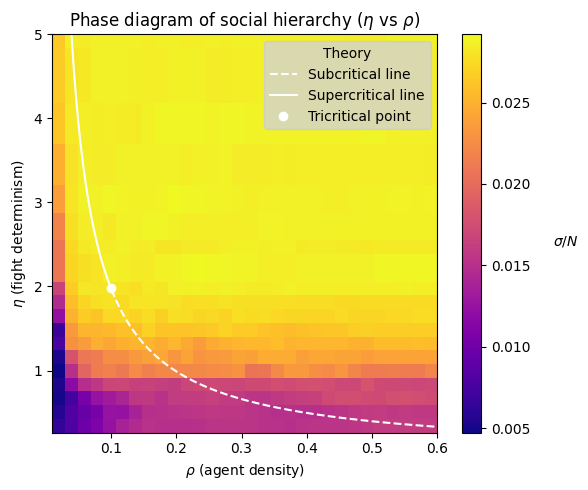

In [182]:
plt.figure(figsize=(6, 5))
# Courbe globale
rho_curve = np.linspace(min(rho_values), max(rho_values), 500)
eta_curve = 2 * mu / ((1 + 1/N) * rho_curve)

# Séparation des domaines
mask_sub = rho_curve < 0.1
mask_super = rho_curve > 0.1
mask_tri = np.isclose(rho_curve, 0.1, atol=1e-3)  # tolérance pour le point tricritique

plt.imshow(Z_1, origin='lower', aspect='auto',
           extent=[min(rho_values), max(rho_values), min(eta_values), max(eta_values)],
           cmap='plasma')


# Plot subcritical line (rho > 0.1) – pointillé
plt.plot(rho_curve[mask_super], eta_curve[mask_super], linestyle='--', color='white', label="Subcritical line")

# Plot supercritical line (rho < 0.1) – plein
plt.plot(rho_curve[mask_sub], eta_curve[mask_sub], linestyle='-', color='white', label="Supercritical line")

# Plot tricritical point
rho_tri = 0.1
eta_tri = 2 * mu / ((1 + 1/N) * rho_tri)
plt.plot(rho_tri, eta_tri, 'o', color='white', label="Tricritical point")

#plt.plot(rho_curve, eta_curve, color='white', linestyle='--', label=r"$\eta = \frac{2\mu}{(1 + \frac{1}{N}) \rho}$")


cbar = plt.colorbar()
cbar.set_label(r"$\sigma / N$", rotation=0, labelpad=25)
plt.xlabel(r"$\rho$ (agent density)")
plt.ylim(0.26,5)
plt.ylabel(r"$\eta$ (fight determinism)")
plt.title("Phase diagram of social hierarchy ($\eta$ vs $\\rho$)")
plt.legend(title="Theory", facecolor='lightgray')
plt.tight_layout()
plt.show()